# Novo modelo de extraçao de dados de NFs 

## 1. Processamento PDF => Imagem => OCR

In [ ]:
%pip install -q timm

In [1]:
import os
from io import StringIO
from pathlib import Path
from PIL import Image
from pathlib import WindowsPath
from PIL import Image

In [2]:
#Diretório TESTE raiz para documentos PDF pesquisaveis
root_directory = '.'  # Diretório raiz TESTE


#Diretório raiz para documentos geracao de JSON TESTE
target_directory = '.'

poppler_path = "/home/dani-boy/miniconda3/envs/tables-detr/bin"


#Usada para registar os numeros de paginas do PDF
pdf_pages = r"page_"

### 1.1. Arquivos para teste

In [3]:
file = "pipeline_extracao_documentos/6_geral_administacao/temp_docs/images/processadas/1_5145819163654095684_page_32.jpg"

In [55]:
file = "pipeline_extracao_documentos/2_documentos_para_extracao/21_aguardando_processamento/Batch_17/jubarte/1_5145819163654095684_page_29.pdf"

In [38]:
file

'pipeline_extracao_documentos/2_documentos_para_extracao/21_aguardando_processamento/Batch_17/jubarte/1_5145819163654095684_page_25.pdf'

### 1.2. Conversao PDF => Imagem

In [82]:
file = "Captura de tela 2023-09-11 080330.png"

In [56]:
# Yes!!!!!
from pdf2image import convert_from_path
pages = convert_from_path(file, 500,poppler_path)

In [57]:
pages

[<PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=4132x5848>]

In [58]:
len(pages)

1

In [59]:
image_counter = 1

for page in pages:
    filename = pdf_pages + str(image_counter) + ".jpg"
    page.save(filename, 'JPEG')
    image_counter = image_counter + 1

### 1.3 Executando o OCR

In [83]:
Image_file = file

In [10]:
factor = 0.5

In [84]:
# Using factor variable
file_path = Image_file
image = Image.open(file_path).convert("RGB")

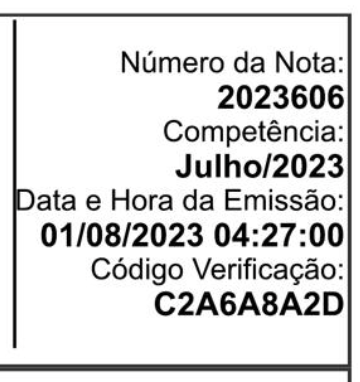

In [85]:
image

In [63]:
resized_page = image.resize((2067, 2923))

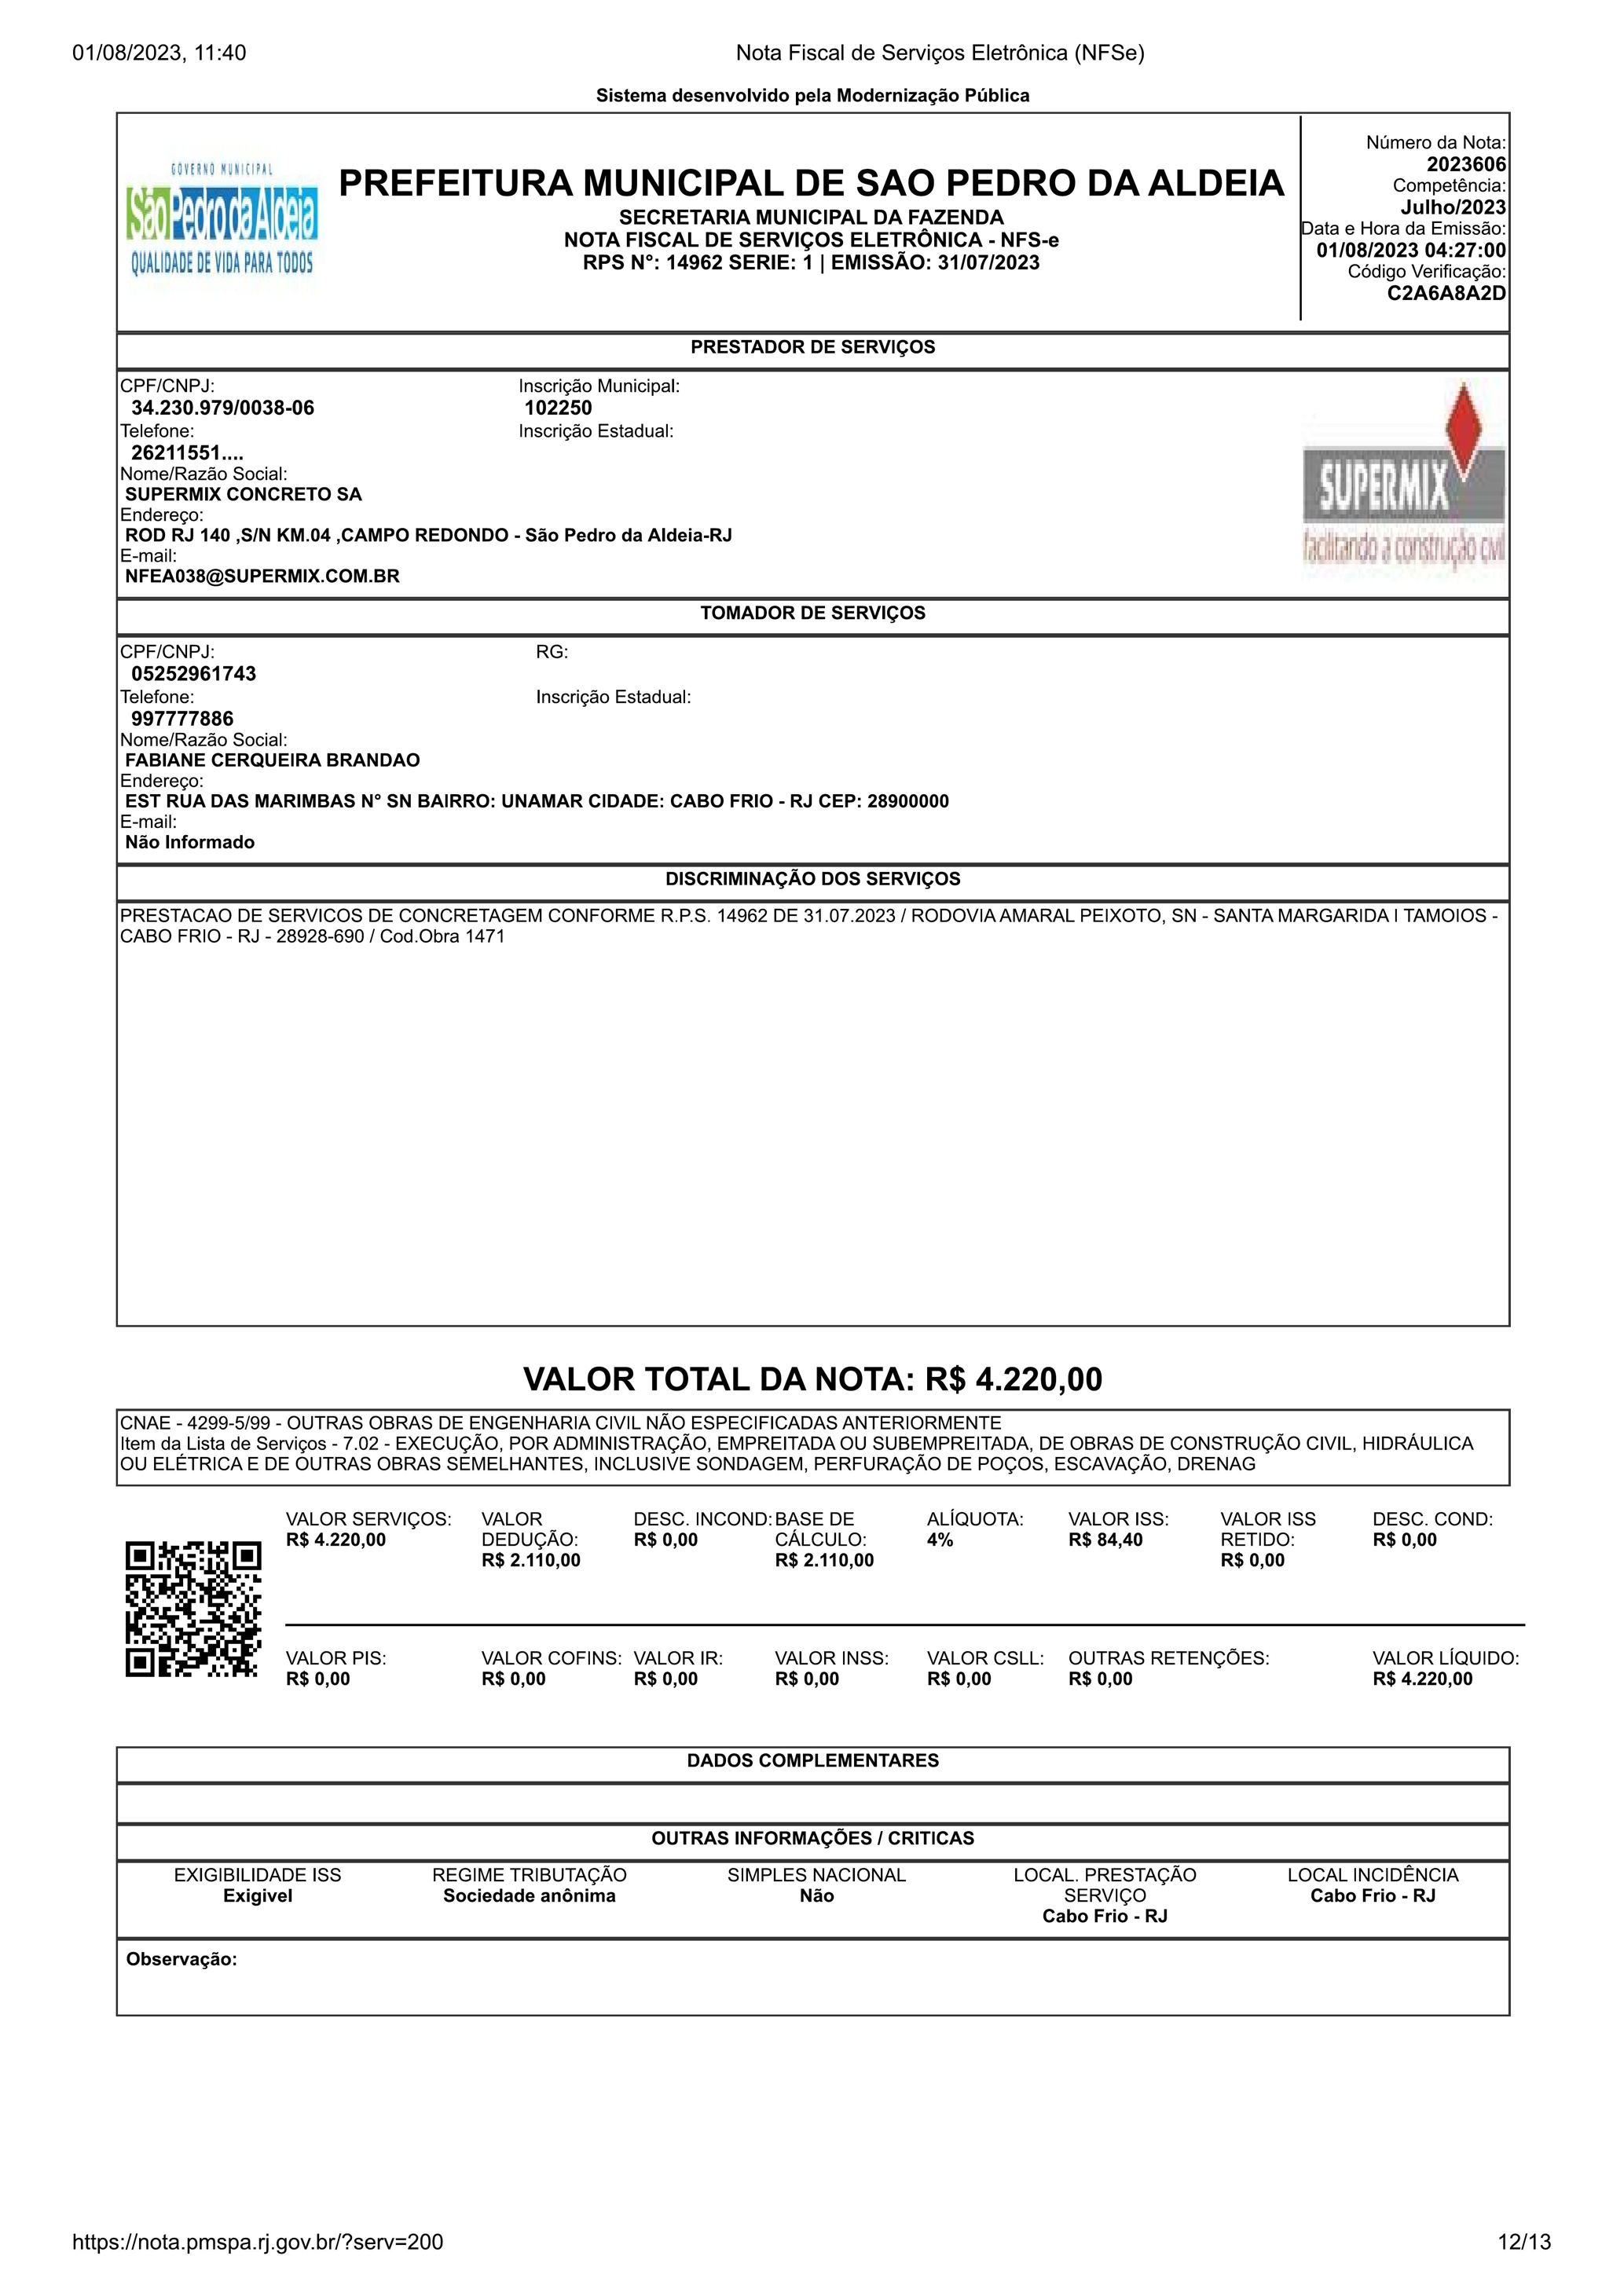

In [80]:
resized_page

In [65]:
x0 = 1633.0 
y0 = 0.0
x1 = 2067.0
y1 = 400.0

In [66]:
image_croped = resized_page.crop((x0, y0, x1, y1))

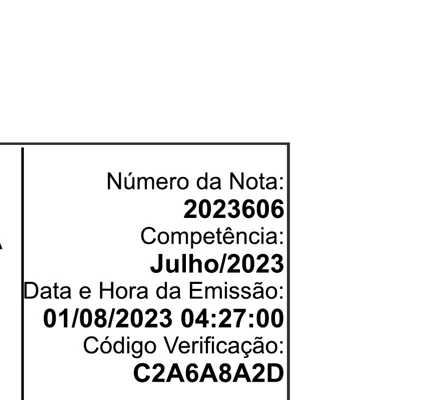

In [67]:
image_croped

In [70]:
factor = 2

In [71]:

width, height = image.size
image_croped_resized = image_croped.resize((int(width*factor), int(height*factor)))

In [ ]:
image_croped_resized

In [25]:
from PIL import Image

import pytesseract

In [ ]:
Image_file = ""

In [86]:
# Portuguese text image to string
texto = pytesseract.image_to_string(image, lang='por')

In [ ]:
# Portuguese text image to string
text = pytesseract.image_to_string(Image.open(Image_file), lang='por')

In [88]:
texto

'Número da Nota:\n2023606\nCompetência:\nJulho/2023\n\nata e Hora da Emissão:\n01/08/2023 04:27:00\nCódigo Verificação:\nC2A6ABA2D\n\n'

In [29]:
text_splited = texto.split('\n')

In [30]:
text_splited

['Número da Nota:',
 '2023616',
 'Competência:',
 'Julho/2023)',
 '',
 'ata e Hora da Emissão:',
 '01/08/2023 09:28:00',
 'Código Verificação:',
 '0AF246074',
 '']

In [31]:
text_splited = [x for x in text_splited if x.strip()]

In [32]:
text_splited

['Número da Nota:',
 '2023616',
 'Competência:',
 'Julho/2023)',
 'ata e Hora da Emissão:',
 '01/08/2023 09:28:00',
 'Código Verificação:',
 '0AF246074']

In [34]:
# 6. XXX Ajusta texto para PDF RASTER NO CABECALHO
def texto_extraido_cabecalho(texto):
    #0. Tratamento da string
    text_splited = texto.split('\n')
    text_splited = [x for x in text_splited if x.strip()]
    text_splited = [s.replace(";", "").strip() for s in text_splited] #depende da situaçao
    text_splited = [s.replace(")", "").strip() for s in text_splited] #depende da situaçao
    return text_splited

In [35]:
texto_tratado = texto_extraido_cabecalho(texto)

In [36]:
texto_tratado

['Número da Nota:',
 '2023616',
 'Competência:',
 'Julho/2023',
 'ata e Hora da Emissão:',
 '01/08/2023 09:28:00',
 'Código Verificação:',
 '0AF246074']

In [ ]:
F131046A9
FF92A3130
E447ECB55
3C7775AB1
0C331612E
EB37E5CBE
27E902CBA

0AF246074


In [ ]:
texto_tratado

## 2. Pre-processamento TEXTO

In [ ]:
# Exemplode funçao Pre-processamento do texto

import re

def preprocess_text(text):
    # Remover quebras de página e espaços extras
    text = re.sub(r'\n+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    
    # Remover caracteres especiais que não sejam letras, números ou espaços
    text = re.sub(r'[^\w\s]', '', text)
    
    return text

In [ ]:
preprocessed_text = preprocess_text(text)

In [ ]:
preprocessed_text

In [ ]:
def compose_new_document(pdf_text):
    # Substituir quebras de página por espaços
    pdf_text = re.sub(r'\n+', ' ', pdf_text)
    
    # Encontrar padrões de campo e valor e separá-los em linhas distintas
    new_lines = []
    for match in re.finditer(r'([^:]+):\s*(.+?)(?=\s+[^\s:]+:|$)', pdf_text):
        field = match.group(1).strip()
        value = match.group(2).strip()
        new_lines.append(f"{field}:\n{value}")
    
    # Compor o novo documento com os campos e valores em linhas distintas
    new_document = '\n'.join(new_lines)
    
    return new_document

In [ ]:
new_document = compose_new_document(text)

In [ ]:
print(new_document)

In [ ]:
import os
import re
import json
import fitz
from pdfminer.high_level import extract_pages
from pdfminer.layout import LTTextContainer, LTChar

In [ ]:
nf_data_tomador = {}

# Extrair Inscrição Municipal
inscricao_municipal_match = re.search(r'Inscrição Municipal:\s+(.+)', text)
if inscricao_municipal_match:
    nf_data_tomador['Inscrição Municipal'] = inscricao_municipal_match.group(1)

In [ ]:
for key, value in nf_data_tomador.items():
    print(f"{key}: {value}")

In [ ]:
# Remover quebras de linha
text = text.replace('\n', ' ')

In [ ]:
text

# Modelo Anterior - pesquisa por Regex in Boxes

### 1. Modulos e paths

In [ ]:
import os
import fitz  # Módulo PyMuPDF
import re
import json
import PyPDF2
from pdfminer.high_level import extract_pages
from pdfminer.layout import LTTextContainer, LTChar
from pathlib import Path
from unidecode import unidecode

<h3>Path - Documentos PDF para Extracao e geracao de JSONS - <mark>producao</mark></h3>

In [ ]:

#Diretório raiz para documentos PDF pesquisaveis
root_directory = '.\\data\data_pdf\NF_para_processamento'  # Diretório raiz 


#Diretório raiz para documentos geracao de JSON
target_directory = '.\\data\data_pdf\Gravacao_json'






<h3><mark>TESTE</mark> - Path - Documentos PDF para Extracao e geracao de JSONS - <mark>TESTE</mark></h3>

In [ ]:
#Diretório TESTE raiz para documentos PDF pesquisaveis
root_directory = '.\\data\data_teste'  # Diretório raiz TESTE


#Diretório raiz para documentos geracao de JSON TESTE
target_directory = '.\\data\data_teste\Gravacao_json_teste'

nro_nota_fiscal = 0 


### 2. Analise de arquivos e quantidades

<h4> 2.1 Analise de PDF Pesquisavel </h4>

In [ ]:
def is_pdf_searchable(pdf_path):
    try:
        pdf_document = fitz.open(pdf_path)
        is_searchable = all(page.get_text("text") != "" for page in pdf_document)
        pdf_document.close()
        return is_searchable
    except Exception as e:
        print(f"Erro ao verificar o PDF: {e}")
        return False


pdf_image_info = []  # Lista para armazenar informações sobre PDFs e imagens

for root, dirs, files in os.walk(root_directory):
    for file in files:
        file_path = os.path.join(root, file)
        
        if file.lower().endswith('.pdf'):
            if is_pdf_searchable(file_path):
                pdf_image_info.append({
                    "subdiretorio": os.path.relpath(root, root_directory),
                    "nome_arquivo": file,
                    "tipo": "PDF",
                    "status": "O PDF é pesquisável"
                })
            else:
                pdf_image_info.append({
                    "subdiretorio": os.path.relpath(root, root_directory),
                    "nome_arquivo": file,
                    "tipo": "PDF",
                    "status": "O PDF não é pesquisável"
                })
        elif any(file.lower().endswith(ext) for ext in ['.jpg', '.jpeg', '.png', '.gif']):
            pdf_image_info.append({
                "subdiretorio": os.path.relpath(root, root_directory),
                "nome_arquivo": file,
                "tipo": "IMAGEM"
            })

# Iterando e exibindo as informações coletadas
for item in pdf_image_info:
    print(f"Subdiretório: {item['subdiretorio']} \n\nNome do arquivo: {item['nome_arquivo']}, Tipo: {item['tipo']}")
    if 'status' in item:
        print(f"\nStatus: {item['status']}")
    print("-" * 40)


<h4> 2.2 Analise de Quantitativos </h4>

In [ ]:
# Analise de PDFs 
import os
import fitz  # Módulo PyMuPDF

def is_pdf_searchable(pdf_path):
    try:
        pdf_document = fitz.open(pdf_path)
        is_searchable = all(page.get_text("text") != "" for page in pdf_document)
        pdf_document.close()
        return is_searchable
    except Exception as e:
        print(f"Erro ao verificar o PDF: {e}")
        return False

pdf_image_info = {}  # Dicionário para armazenar informações sobre PDFs e imagens

for root, dirs, files in os.walk(root_directory):
    dir_name = os.path.basename(root)  # Nome do diretório no último nível
    pdf_image_info[dir_name] = pdf_image_info.get(dir_name, {"total": 0})
    
    for file in files:
        file_path = os.path.join(root, file)
        
        if file.lower().endswith('.pdf'):
            if is_pdf_searchable(file_path):
                status = "O PDF é pesquisável"
            else:
                status = "O PDF não é pesquisável"
                
            pdf_image_info[dir_name]["total"] += 1
            pdf_image_info[dir_name].setdefault("pdf_pesquisavel", 0)
            pdf_image_info[dir_name].setdefault("pdf_nao_pesquisavel", 0)
            
            if status == "O PDF é pesquisável":
                pdf_image_info[dir_name]["pdf_pesquisavel"] += 1
            else:
                pdf_image_info[dir_name]["pdf_nao_pesquisavel"] += 1
        elif any(file.lower().endswith(ext) for ext in ['.jpg', '.jpeg', '.png', '.gif']):
            pdf_image_info[dir_name].setdefault("total", 0)
            pdf_image_info[dir_name].setdefault("imagens", 0)
            pdf_image_info[dir_name]["total"] += 1
            pdf_image_info[dir_name].setdefault("imagens", 0)
            pdf_image_info[dir_name]["imagens"] += 1

# Salvando as informações em um arquivo JSON
json_file_path = os.path.join(target_directory, "pdf_image_info.json")
with open(json_file_path, "w") as json_file:
    json.dump(pdf_image_info, json_file, indent=4)

print(f"As informações foram salvas em {json_file_path}")



#json_file_path = os.path.join(target_directory, f"{os.path.splitext(file)[0]}.json")

## Processo gravando um unico arquivo

### 1 - Leioute geral

In [ ]:
nf_data_servico = {}
def is_pdf_searchable(pdf_path):
    try:
        pdf_document = fitz.open(pdf_path)
        is_searchable = all(page.get_text("text") != "" for page in pdf_document)
        pdf_document.close()
        return is_searchable
    except Exception as e:
        print(f"Erro ao verificar o PDF: {e}")
        return False

# 1. CABECALHO
def extract_fields_cabecalho(text):
    nf_data_cabecalho = {}
    nf_data_cabecalho['secao'] = "1 - CABECALHO"
    
    # Extrair Nome da Prefeitura
    nome_prefeitura_match = re.search(r'PREFEITURA (.+)', text)
    if nome_prefeitura_match:
        nome_prefeitura = "PREFEITURA " + nome_prefeitura_match.group(1)
        nf_data_cabecalho['nome_prefeitura'] = nome_prefeitura

    # Extrair Tipo de NF
    tipo_nf_match = re.search(r'NOTA FISCAL (.+)', text)
    if tipo_nf_match:
        tipo_nf = "NOTA FISCAL " + tipo_nf_match.group(1)
        nf_data_cabecalho['tipo_nota_fiscal'] = tipo_nf
    
    # Extrair Número da Nota
    numero_nota_match = re.search(r'Número da Nota:\s+(\d+)', text)
    if numero_nota_match:
        nr_nro_nf = numero_nota_match.group(1)
        nf_data_cabecalho['numero_nota_fiscal'] = numero_nota_match.group(1)
    else:
        nr_nro_nf = 0    

    # Extrair Competência
    competencia_match = re.search(r'Competência:\s+(.+)', text)
    if competencia_match:
        nf_data_cabecalho['competencia'] = competencia_match.group(1)

    # Extrair Data e Hora de Emissão
    data_emissao_match = re.search(r'Data e Hora da Emissão:\s+(.+)', text)
    if data_emissao_match:
        nf_data_cabecalho['dt_hr_emissao'] = data_emissao_match.group(1)
        
    # Extrair Data e Hora de Emissão
    codigo_verificacao_match = re.search(r'Código Verificação:\s+(.+)', text)
    if codigo_verificacao_match:
        nf_data_cabecalho['codigo_verificacao'] = codigo_verificacao_match.group(1)    

    return nf_data_cabecalho, nr_nro_nf

# 2. PRESTADOR DE SERVIÇO
def extract_fields_prestador(text): # Função para extrair campos e valores dentro de um retângulo
    nf_data_prestador = {}
    
    nf_data_prestador['secao'] = "2. PRESTADOR DE SERVIÇO"
    
    
    # Extrair CPF/CNPJ com máscara 1
    if "CPF/CNPJ:" in text:
        cpf_cnpj_formatado_match = re.search(r'(\d{2}\.\d{3}\.\d{3}/\d{4}-\d{2})', text)
        if cpf_cnpj_formatado_match:
                        nf_data_prestador['cpf_cnpj_com_mascara'] = cpf_cnpj_formatado_match.group(1)
                        nf_data_prestador['cpf_cnpj_sem_mascara'] = re.sub(r'\D', '', cpf_cnpj_formatado_match.group(1))

    # Extrair Inscrição Municipal
    inscricao_municipal_match = re.search(r'Inscrição Municipal:\s+(.+)', text)
    if inscricao_municipal_match:
        nf_data_prestador['inscricao_municipal'] = inscricao_municipal_match.group(1)
        
               
    # Extrair Inscrição Estadual
    #if "Inscrição Estadual:" in text:
    
    # Extrair Inscrição Estadual
    inscricao_estadual_match = re.search(r'Inscrição Estadual:\s+(.+)', text)
    if inscricao_estadual_match:
        inscricao_estadual_str = inscricao_estadual_match.group(1)
        if inscricao_estadual_str == 'Nome/Razão Social:':
            nf_data_prestador['inscricao_estadual'] = "NONE"
        else:    
            nf_data_prestador['inscricao_estadual'] = inscricao_estadual_match.group(1)       
        
                
    

    # Extrair Telefone
    #telefone_match = re.search(r'Telefone:\s+([0-9.\s-])', text)
    telefone_match = re.search(r'Telefone:\s+([0-9.\s-]+)', text)
    if telefone_match: 
        telefone_str = telefone_match.group(1)
        # Remover quebras de linha
        telefone_str = telefone_str.replace('.', '')
        telefone_str = telefone_str.replace('\n', '')
                
        nf_data_prestador['telefone'] = telefone_str
    else:
        nf_data_prestador['telefone'] = "NONE"

         
                
    # Nome/Razão Social:
    razao_social_match = re.search(r'Nome/Razão Social:\s+(.+)', text)
    if razao_social_match:
        nf_data_prestador['razao_social'] = razao_social_match.group(1)  
                
    # Nome de Fantasia:
    nome_fantasia_match = re.search(r'Nome de Fantasia:\s+(.+)', text)
    if nome_fantasia_match:
        nf_data_prestador['nome_fantasia'] = nome_fantasia_match.group(1)                                    
                
            
    # Endereço:
    endereco_match = re.search(r'Endereço:\s+(.+)', text)
    if endereco_match:
        nf_data_prestador['endereco'] = endereco_match.group(1) 
    
    # E-mail:
    email_match = re.search(r'E-mail:\s+(.+)', text)
    if email_match:
        nf_data_prestador['email'] = email_match.group(1)  
    else:
        nf_data_prestador['email'] = "NONE"  # Valor padrão quando não há correspondência
   
        

    return nf_data_prestador


# Função para extrair campos e valores dentro de um retângulo
def extract_fields_tomador(text):
    nf_data_tomador = {}
    
    
    nf_data_tomador['secao'] = "3. TOMADOR DE SERVIÇO"
    
    
    # Extrair CPF/CNPJ com máscara 1
    if "CPF/CNPJ:" in text:
        cpf_cnpj_formatado_match = re.search(r'(\d{2}\.\d{3}\.\d{3}/\d{4}-\d{2})', text)
        if cpf_cnpj_formatado_match:
                        nf_data_tomador['cpf_cnpj_com_mascara'] = cpf_cnpj_formatado_match.group(1)
                        nf_data_tomador['cpf_cnpj_sem_mascara'] = re.sub(r'\D', '', cpf_cnpj_formatado_match.group(1))

        
    # Extrair RG    
    rg_match = re.search(r'RG:\s+(.+)', text)   
    if rg_match:
        rg_str = rg_match.group(1)
        if rg_str == 'Telefone:':
            nf_data_tomador['rg'] = "NONE"  # Valor padrão quando não há correspondência
        else:    
            nf_data_tomador['rg'] = rg_match.group(1)  
 
        
    # Extrair Telefone
    telefone_match = re.search(r'Telefone:\s+(.+)', text)
    if telefone_match:
        telefone_str = telefone_match.group(1)
        if telefone_str == 'Inscrição Estadual:':
            nf_data_tomador['telefone'] = "NONE"  # Valor padrão quando não há correspondência
        else:    
            nf_data_tomador['telefone'] = telefone_match.group(1)
     

    # Extrair Inscrição Municipal
    inscricao_municipal_match = re.search(r'Inscrição Municipal:\s+(.+)', text)
    if inscricao_municipal_match:
        nf_data_tomador['inscricao_municipal'] = inscricao_municipal_match.group(1)
                
                
                
    # Extrair Inscrição Estadual
    inscricao_estadual_match = re.search(r'Inscrição Estadual:\s+(.+)', text)
    if inscricao_estadual_match:
        inscricao_estadual_str = inscricao_estadual_match.group(1)
        if inscricao_estadual_str == 'Nome/Razão Social:':
            nf_data_tomador['inscricao_estadual'] = "NONE"
        else:    
            nf_data_tomador['inscricao_estadual'] = inscricao_estadual_match.group(1)   
                
    
    # Nome/Razão Social:
    razao_social_match = re.search(r'Nome/Razão Social:\s+(.+)', text)
    if razao_social_match:
        nf_data_tomador['razao_social'] = razao_social_match.group(1)                                                
                
    # Endereço:
    endereco_match = re.search(r'Endereço:\s+(.+)', text)
    if endereco_match:
        nf_data_tomador['endereco'] = endereco_match.group(1) 
    
    # E-mail:
    email_match = re.search(r'E-mail:\s+(.+)', text)
    if email_match:
        nf_data_tomador['email'] = email_match.group(1) 
    else:
        nf_data_tomador['email'] = "NONE"  # Valor padrão quando não há correspondência    

    return nf_data_tomador

# 7. VALORES E IMPOSTOS

# Função para extrair campos e valores dentro de um retângulo
def extract_fields_impostos(text):
    nf_data_valores = {}
    nf_data_valores['secao'] = "7. VALORES E IMPOSTOS"
    
    # Extrair VALOR SERVIÇOS:
    valor_servicos_match = re.search(r'VALOR SERVIÇOS:\s+(.+)', text)
    if valor_servicos_match:
        valor_servicos_str = valor_servicos_match.group(1)
        valor_servicos_sem_formato = re.search(r'R\$\s*([\d.,]+)', valor_servicos_str)
        if valor_servicos_sem_formato:
            valor_servicos_sem_formatacao = valor_servicos_sem_formato.group(1).replace('.', '').replace(',', '.').strip()
            nf_data_valores['valor_servicos'] = float(valor_servicos_sem_formatacao)
        else:
            nf_data_valores['valor_servicos'] = 0.0  # Valor não encontrado ou não está no formato esperado
  
  
    # Extrair VALOR DEDUÇÃO:
    valor_deducao_match = re.search(r'DEDUÇÃO:\s+(.+)', text)
    if valor_deducao_match:
        valor_deducao_str = valor_deducao_match.group(1)
        valor_deducao_sem_formato = re.search(r'R\$\s*([\d.,]+)', valor_deducao_str)
        if valor_deducao_sem_formato:
            valor_deducao_sem_formato = valor_deducao_sem_formato.group(1).replace('.', '').replace(',', '.').strip()
            nf_data_valores['valor_deducao'] = float(valor_deducao_sem_formato)
        else:
            nf_data_valores['valor_deducao'] = 0.0  # Valor não encontrado ou não está no formato esperado
        
        
    # Extrair DESC. INCOND:
    valor_desc_match = re.search(r'DESC. INCOND:\s+(.+)', text)
    if valor_desc_match:
        valor_desc_str = valor_desc_match.group(1)
        valor_desc_sem_formato = re.search(r'R\$\s*([\d.,]+)', valor_desc_str)
        if valor_desc_sem_formato:
            valor_desc_sem_formato = valor_desc_sem_formato.group(1).replace('.', '').replace(',', '.').strip()
            nf_data_valores['desc_incond'] = float(valor_desc_sem_formato)
        else:
            nf_data_valores['desc_incond'] = 0.0  # Valor não encontrado ou não está no formato esperado        
        

    # Extrair BASE DE CÁLCULO:
    valor_calculo_match = re.search(r'CÁLCULO:\s+(.+)', text)
    if valor_calculo_match:
        valor_calculo_str = valor_calculo_match.group(1)
        valor_calculo_sem_formato = re.search(r'R\$\s*([\d.,]+)', valor_calculo_str)
        if valor_calculo_sem_formato:
            valor_calculo_sem_formato = valor_calculo_sem_formato.group(1).replace('.', '').replace(',', '.').strip()
            nf_data_valores['base_calculo'] = float(valor_calculo_sem_formato)
        else:
            nf_data_valores['base_calculo'] = 0.0  # Valor não encontrado ou não está no formato esperado    



    # Extrair ALÍQUOTA:
    valor_aliquota_match = re.search(r'ALÍQUOTA:\s+(.+)', text)
    if valor_aliquota_match:
        valor_aliquota_str = valor_aliquota_match.group(1)
        valor_aliquota_sem_formato = re.search(r'([\d.,]+)%', valor_aliquota_str)  # Ajuste aqui
        if valor_aliquota_sem_formato:
            valor_aliquota_sem_formato = valor_aliquota_sem_formato.group(1).replace('.', '').replace(',', '.').strip()
            nf_data_valores['aliquota'] = float(valor_aliquota_sem_formato)
        else:
            nf_data_valores['aliquota'] = 0.0  # Valor não encontrado ou não está no formato esperado


    # Extrair VALOR ISS:
    valor_iss_match = re.search(r'VALOR ISS:\s+(.+)', text)
    if valor_iss_match:
        valor_iss_str = valor_iss_match.group(1)
        valor_iss_sem_formato = re.search(r'R\$\s*([\d.,]+)', valor_iss_str)
        if valor_iss_sem_formato:
            valor_iss_sem_formato = valor_iss_sem_formato.group(1).replace('.', '').replace(',', '.').strip()
            nf_data_valores['valor_iss'] = float(valor_iss_sem_formato)
        else:
            nf_data_valores['valor_iss'] = 0.0  # Valor não encontrado ou não está no formato esperado 

    # Extrair VALOR ISS RETIDO:
    valor_iss_retido_match = re.search(r'RETIDO:\s+(.+)', text)
    if valor_iss_match:
        valor_iss_retido_str = valor_iss_retido_match.group(1)
        valor_iss_retido_sem_formato = re.search(r'R\$\s*([\d.,]+)', valor_iss_retido_str)
        if valor_iss_retido_sem_formato:
            valor_iss_retido_sem_formato = valor_iss_retido_sem_formato.group(1).replace('.', '').replace(',', '.').strip()
            nf_data_valores['valor_iss_retido'] = float(valor_iss_retido_sem_formato)
        else:
            nf_data_valores['valor_iss_retido'] = 0.0  # Valor não encontrado ou não está no formato esperado 

    # Extrair VALOR DESC. COND:
    valor_desc_cond_match = re.search(r'DESC. COND:\s+(.+)', text)
    if valor_desc_cond_match:
        valor_desc_cond_str = valor_desc_cond_match.group(1)
        valor_desc_cond_sem_formato = re.search(r'R\$\s*([\d.,]+)', valor_desc_cond_str)
        if valor_desc_cond_sem_formato:
            valor_desc_cond_sem_formato = valor_desc_cond_sem_formato.group(1).replace('.', '').replace(',', '.').strip()
            nf_data_valores['desc_cond'] = float(valor_desc_cond_sem_formato)
        else:
            nf_data_valores['desc_cond'] = 0.0  # Valor não encontrado ou não está no formato esperado
    
    # Extrair VALOR PIS:
    valor_pis_match = re.search(r'VALOR PIS:\s+(.+)', text)
    if valor_pis_match:
        valor_pis_str = valor_pis_match.group(1)
        valor_pis_sem_formato = re.search(r'R\$\s*([\d.,]+)', valor_pis_str)
        if valor_pis_sem_formato:
            valor_pis_sem_formato = valor_pis_sem_formato.group(1).replace('.', '').replace(',', '.').strip()
            nf_data_valores['valor_pis'] = float(valor_pis_sem_formato)
        else:
            nf_data_valores['valor_pis'] = 0.0  # Valor não encontrado ou não está no formato esperado
    
    # Extrair VALOR COFINS:
    valor_cofins_match = re.search(r'VALOR COFINS:\s+(.+)', text)
    if valor_cofins_match:
        valor_cofins_str = valor_cofins_match.group(1)
        valor_cofins_sem_formato = re.search(r'R\$\s*([\d.,]+)', valor_cofins_str)
        if valor_cofins_sem_formato:
            valor_cofins_sem_formato = valor_cofins_sem_formato.group(1).replace('.', '').replace(',', '.').strip()
            nf_data_valores['valor_cofins'] = float(valor_cofins_sem_formato)
        else:
            nf_data_valores['valor_cofins'] = 0.0  # Valor não encontrado ou não está no formato esperado
            
    # Extrair VALOR IR:
    valor_ir_match = re.search(r'VALOR IR:\s+(.+)', text)
    if valor_ir_match:
        valor_ir_str = valor_ir_match.group(1)
        valor_ir_sem_formato = re.search(r'R\$\s*([\d.,]+)', valor_ir_str)
        if valor_ir_sem_formato:
            valor_ir_sem_formato = valor_ir_sem_formato.group(1).replace('.', '').replace(',', '.').strip()
            nf_data_valores['valor_ir'] = float(valor_ir_sem_formato)
        else:
            nf_data_valores['valor_ir'] = 0.0  # Valor não encontrado ou não está no formato esperado
            
    # Extrair VALOR INSS:
    valor_inss_match = re.search(r'VALOR INSS:\s+(.+)', text)
    if valor_inss_match:
        valor_inss_str = valor_inss_match.group(1)
        valor_inss_sem_formato = re.search(r'R\$\s*([\d.,]+)', valor_inss_str)
        if valor_inss_sem_formato:
            valor_inss_sem_formato = valor_inss_sem_formato.group(1).replace('.', '').replace(',', '.').strip()
            nf_data_valores['valor_inss'] = float(valor_inss_sem_formato)
        else:
            nf_data_valores['valor_inss'] = 0.0  # Valor não encontrado ou não está no formato esperado
            
    # Extrair VALOR CSLL:
    valor_csll_match = re.search(r'VALOR CSLL:\s+(.+)', text)
    if valor_csll_match:
        valor_csll_str = valor_csll_match.group(1)
        valor_csll_sem_formato = re.search(r'R\$\s*([\d.,]+)', valor_csll_str)
        if valor_csll_sem_formato:
            valor_csll_sem_formato = valor_csll_sem_formato.group(1).replace('.', '').replace(',', '.').strip()
            nf_data_valores['valor_csll'] = float(valor_csll_sem_formato)
        else:
            nf_data_valores['valor_csll'] = 0.0  # Valor não encontrado ou não está no formato esperado
    
    # Extrair OUTRAS RETENÇÕES:
    outras_retencoes_match = re.search(r'OUTRAS RETENÇÕES:\s+(.+)', text)
    if outras_retencoes_match:
        outras_retencoes_str = outras_retencoes_match.group(1)
        outras_retencoes_sem_formato = re.search(r'R\$\s*([\d.,]+)', outras_retencoes_str)
        if outras_retencoes_sem_formato:
            outras_retencoes_sem_formato = outras_retencoes_sem_formato.group(1).replace('.', '').replace(',', '.').strip()
            nf_data_valores['outras_retencoes'] = float(outras_retencoes_sem_formato)
        else:
            nf_data_valores['outras_retencoes'] = 0.0  # Valor não encontrado ou não está no formato esperado
    
    
    # Extrair VALOR LÍQUIDO:
    valor_liquido_match = re.search(r'VALOR LÍQUIDO:\s+(.+)', text)
    if valor_liquido_match:
        valor_liquido_str = valor_liquido_match.group(1)
        valor_liquido_sem_formato = re.search(r'R\$\s*([\d.,]+)', valor_liquido_str)
        if valor_liquido_sem_formato:
            valor_liquido_sem_formato = valor_liquido_sem_formato.group(1).replace('.', '').replace(',', '.').strip()
            nf_data_valores['valor_liquido'] = float(valor_liquido_sem_formato)
        else:
            nf_data_valores['valor_liquido'] = 0.0  # Valor não encontrado ou não está no formato esperado
        

    return nf_data_valores


# 9. OUTRAS INFORMAÇOES / CRITICAS
# Função para extrair campos e valores dentro de um retângulo
def extract_fields_outras_info(text):
    nf_data_outras_informacoes = {}
    nf_data_outras_informacoes['secao'] = "9. OUTRAS INFORMAÇOES / CRITICAS"
    
    # Extrair EXIGIBILIDADE ISS:
    exigibilidade_iss_match = re.search(r'EXIGIBILIDADE ISS\s+(.+)', text)
    if exigibilidade_iss_match:
        exigibilidade_iss_value = exigibilidade_iss_match.group(1).strip()
        nf_data_outras_informacoes['exigibilidade_iss'] = exigibilidade_iss_value
        
    # Extrair REGIME TRIBUTAÇÃO:
    regime_tributacao_match = re.search(r'REGIME TRIBUTAÇÃO\s+(.+)', text)
    if regime_tributacao_match:
        regime_tributacao_value = regime_tributacao_match.group(1).strip()
        nf_data_outras_informacoes['regime_tributacao'] = regime_tributacao_value
    
    # Extrair SIMPLES NACIONAL:
    simples_nacional_match = re.search(r'SIMPLES NACIONAL\s+(.+)', text)
    if simples_nacional_match:
        simples_nacional_value = simples_nacional_match.group(1).strip()
        nf_data_outras_informacoes['simples_nacional'] = simples_nacional_value
        
        
    # Extrair ISSQN RETIDO:
    local_prestacao_servico_match = re.search(r'ISSQN RETIDO\s+(.+)', text)
    if local_prestacao_servico_match:
        local_prestacao_servico_value = local_prestacao_servico_match.group(1).strip()
        nf_data_outras_informacoes['issqn_retido'] = local_prestacao_servico_value        
        
    
    # Extrair LOCAL PRESTAÇÃO SERVIÇO:
    local_prestacao_servico_match = re.search(r'LOCAL\. PRESTAÇÃO\s+SERVIÇO\s+(.+)', text)
    if local_prestacao_servico_match:
        local_prestacao_servico_value = local_prestacao_servico_match.group(1).strip()
        nf_data_outras_informacoes['local_prestacao_servico'] = local_prestacao_servico_value
    
    
    
    # Extrair LOCAL INCIDÊNCIA:
    local_incidencia_match = re.search(r'LOCAL INCIDÊNCIA\s+(.+)', text)
    if local_incidencia_match:
        local_incidencia_value = local_incidencia_match.group(1).strip()
        nf_data_outras_informacoes['local_incidencia'] = local_incidencia_value
   
    
    return nf_data_outras_informacoes



pdf_info = {}  # Dicionário para armazenar informações sobre PDFs

for root, dirs, files in os.walk(root_directory):
    for file in files:
        file_path = os.path.join(root, file)
        
        if file.lower().endswith('.pdf'):
            if is_pdf_searchable(file_path):
                
                status = "O PDF é pesquisável"
                
                # 1 - cabecalho
                pdf_document = fitz.open(file_path)
                page_number = 0  # Defina o número da página que deseja analisar
                page = pdf_document[page_number]
                x0 = 0
                y0 = 0
                x1 = 600
                y1 = 110
                
                text = page.get_text("text", clip=(x0, y0, x1, y1))
                nf_data_cabecalho, nro_nota = extract_fields_cabecalho(text)
                
                
                # 2. PRESTADOR DE SERVIÇO
                # Definir retângulo de interesse
                x0 = 0
                y0 = 100
                x1 = 600
                y1 = 236  # Ajuste este valor para delimitar a região vertical

                # Extrair texto dentro do retângulo
                text = page.get_text("text", clip=(x0, y0, x1, y1))
                
                nf_data_prestador = extract_fields_prestador(text)
                
                # 3. TOMADOR DE SERVIÇO
                # Definir retângulo de interesse
                x0 = 0
                y0 = 210
                x1 = 600
                y1 = 340  # Ajuste este valor para delimitar a região vertical

                # Extrair texto dentro do retângulo
                text = page.get_text("text", clip=(x0, y0, x1, y1))
                nf_data_tomador = extract_fields_tomador(text)
                
                
                # 4. DESCRIMINACAO DOS SERVIÇOS
                nf_data_servico = {}
                nf_data_servico['secao'] = "4. DESCRIMINACAO DOS SERVIÇOS"
                # Definir retângulo de interesse
                x0 = 0
                y0 = 330
                x1 = 600
                y1 = 500  # Ajuste este valor para delimitar a região vertical

                # Extrair texto dentro do retângulo
                text = page.get_text("text", clip=(x0, y0, x1, y1))

                # Remover quebras de linha e rótulo
                text = text.replace('\n', ' ')
                label = "DISCRIMINAÇÃO DOS SERVIÇOS"
                if text.startswith(label):
                    text = text[len(label):].strip()

                # Atribuir texto ao dicionário
                nf_data_servico['discriminacao_servicos'] = text
                
                
                # 5. VALOR TOTAL
                nf_data_valor_total = {}
                nf_data_valor_total['secao'] = "5. VALOR TOTAL"

                # Definir retângulo de interesse
                x0 = 0
                y0 = 500
                x1 = 600
                y1 = 535  # Ajuste este valor para delimitar a região vertical


                # Extrair texto dentro do retângulo
                text = page.get_text("text", clip=(x0, y0, x1, y1))

                # Usar expressão regular para extrair apenas os caracteres numéricos e pontos decimais
                valor_total_match = re.search(r'R\$ ([\d,.]+)', text)
                if valor_total_match:
                    valor_total_sem_formatacao = valor_total_match.group(1).replace('.', '').replace(',', '.')
                    nf_data_valor_total['valor_total_nota'] = float(valor_total_sem_formatacao)
                    
                    
                # 6. CNAE
                nf_data_CNAE = {}
                nf_data_CNAE['secao'] = "6. CNAE"

                # Definir retângulo de interesse
                x0 = 0
                y0 = 525
                x1 = 600
                y1 = 555  # Ajuste este valor para delimitar a região vertical


                # Extrair texto dentro do retângulo
                text = page.get_text("text", clip=(x0, y0, x1, y1))

                # Remove a primeira ocorrência de "CNAE:"
                text = re.sub(r'^CNAE - ', '', text, count=1)

                # Remover quebras de linha
                text = text.replace('\n', ' ')

                # Extrair texto dentro do retângulo
                nf_data_CNAE['cnae'] = text.strip()
                
                
                # 6. CNAE e Item da Lista de Serviços
                nf_data_CNAE = {}
                nf_data_CNAE['Secao'] = "6. CNAE e Item da Lista de Serviços"

                # Definir retângulo de interesse CNAE
                x0 = 0
                y0 = 525
                x1 = 600
                y1 = 545  # Ajuste este valor para delimitar a região vertical


                # Extrair texto dentro do retângulo
                text = page.get_text("text", clip=(x0, y0, x1, y1))


                # Extrair CNAE
                nf_data_CNAE_match = re.search(r'CNAE\s+(.+)', text)
                if nf_data_CNAE_match:
                    # Remove a primeira ocorrência de "CNAE:"
                    nf_data_CNAE_str = re.sub(r'^CNAE - ', '', text, count=1)
                    # Remover quebras de linha
                    nf_data_CNAE_str = nf_data_CNAE_str.replace('\n', ' ')
                    nf_data_CNAE['cnae'] = nf_data_CNAE_str
                    
                
                
                # Item da Lista de Serviços    
                # Definir retângulo de interesse - Item da Lista de Serviços
                x0 = 0
                y0 = 540
                x1 = 600
                y1 = 560  # Ajuste este valor para delimitar a região vertical    
                # Extrair texto dentro do retângulo
                text = page.get_text("text", clip=(x0, y0, x1, y1))     
                    
                # Extrair Item da Lista de Serviços
                nf_item_lista_servicos_match = re.search(r'Item da Lista de Serviços\s+(.+)', text)
                if nf_item_lista_servicos_match:
                    nf_item_lista_servicos_str = re.sub(r'^Item da Lista de Serviços - ', '', text, count=1) 
                    # Remover quebras de linha
                    #nf_item_lista_servicos_str = nf_item_lista_servicos_str.replace('\n \n', '')
                    nf_item_lista_servicos_str = nf_item_lista_servicos_str.replace('\n', ' ')
                    nf_data_CNAE['item_lista_servicos'] = nf_item_lista_servicos_str
                      
                    
                    
                    
                    
                
                
                # 7. VALORES E IMPOSTOS
                # Definir retângulo de interesse
                x0 = 0
                y0 = 550
                x1 = 600
                y1 = 650  # Ajuste este valor para delimitar a região vertical

                # Extrair texto dentro do retângulo
                text = page.get_text("text", clip=(x0, y0, x1, y1))

                # Extrair campos e valores
                nf_data_valores = extract_fields_impostos(text)
                
                # 8. DADOS COMPLEMENTARES
                nf_data_dados_complementares = {}
                nf_data_dados_complementares['secao'] = "8. DADOS COMPLEMENTARES"

                # Definir retângulo de interesse
                x0 = 0
                y0 = 650
                x1 = 600
                y1 = 680  # Ajuste este valor para delimitar a região vertical

                # Extrair texto dentro do retângulo
                text = page.get_text("text", clip=(x0, y0, x1, y1))
                # Remove a primeira ocorrência de "Observação:"
                text = re.sub(r'^DADOS COMPLEMENTARES', '', text, count=1)
                if text == " ":
                    text = "NONE"
                    nf_data_dados_complementares['dados_complementares'] = text.strip()
                else:    
                    # Extrair texto dentro do retângulo
                    nf_data_dados_complementares['dados_complementares'] = text.strip()
                
                
                
                # 9. OUTRAS INFORMAÇOES / CRITICAS  
                # Definir retângulo de interesse
                x0 = 0
                y0 = 680
                x1 = 600
                y1 = 725  # Ajuste este valor para delimitar a região vertical

                # Extrair texto dentro do retângulo
                text = page.get_text("text", clip=(x0, y0, x1, y1))

                # Extrair campos e valores
                nf_data_outras_informacoes = extract_fields_outras_info(text)
                
                
                # 10. OBSERVACOES
                nf_data_observacao = {}
                nf_data_observacao['secao'] = "10. OBSERVACOES"
                # Definir retângulo de interesse
                x0 = 0
                y0 = 725
                x1 = 600
                y1 = 760  # Ajuste este valor para delimitar a região vertical

                # Extrair texto dentro do retângulo
                text = page.get_text("text", clip=(x0, y0, x1, y1))

                # Remove a primeira ocorrência de "Observação:"
                text = re.sub(r'^Observação:', '', text, count=1)

                # Remover quebras de linha
                text = text.replace('\n', ' ')

                # Extrair texto dentro do retângulo
                nf_data_observacao['observacao'] = text.strip()
                
                
                
                
                nome_arquivo = file
                #pdf_info["diretorio"] = os.path.basename(root)
                pdf_info[nr_nro_nf] = {
                    "dados_NF_PDF": {
                        "data_cabecalho": nf_data_cabecalho,
                        "data_prestador": nf_data_prestador,
                        "data_tomador": nf_data_tomador,
                        "data_servico": nf_data_servico,
                        "data_valor_total": nf_data_valor_total,
                        "data_CNAE": nf_data_CNAE,
                        "data_valores": nf_data_valores,
                        "data_dados_complementares": nf_data_dados_complementares,
                        "data_outras_informacoes": nf_data_outras_informacoes,
                        "data_observacao": nf_data_observacao,
                    },
                    "diretorio": os.path.basename(root),
                    "nome_arquivo": nome_arquivo,
                }
                
                
                pdf_document.close()

# Salvando as informações em um arquivo JSON
json_file_path = os.path.join(target_directory, "MAGEfwdnotasfiscaiscarrier.json")
with open(json_file_path, "w", encoding='utf-8') as json_file:
    json.dump(pdf_info, json_file, ensure_ascii=False, indent=4)

print(f"As informações foram salvas em {json_file_path}")

In [ ]:
                #pdf_info["diretorio"] = os.path.basename(root)
                pdf_info[file] = {
                    "dados_NF_PDF": {
                        "data_cabecalho": nf_data_cabecalho,
                        "data_prestador": nf_data_prestador,
                        "data_tomador": nf_data_tomador,
                        "data_servico": nf_data_servico,
                        "data_valor_total": nf_data_valor_total,
                        "data_CNAE": nf_data_CNAE,
                        "data_valores": nf_data_valores,
                        "data_dados_complementares": nf_data_dados_complementares,
                        "data_outras_informacoes": nf_data_outras_informacoes,
                        "data_observacao": nf_data_observacao,
                    },
                    "diretorio": os.path.basename(root),
                }
                
                
                pdf_document.close()

# Salvando as informações em um arquivo JSON
json_file_path = os.path.join(target_directory, "pdf_info_novissimo.json")
with open(json_file_path, "w", encoding='utf-8') as json_file:
    json.dump(pdf_info, json_file, ensure_ascii=False, indent=4)

print(f"As informações foram salvas em {json_file_path}")

### 2 - Leioute Modernizacao Informatica

In [ ]:
nf_data_servico = {}
def is_pdf_searchable(pdf_path):
    try:
        pdf_document = fitz.open(pdf_path)
        is_searchable = all(page.get_text("text") != "" for page in pdf_document)
        pdf_document.close()
        return is_searchable
    except Exception as e:
        print(f"Erro ao verificar o PDF: {e}")
        return False

# 1. CABECALHO
def extract_fields_cabecalho(text):
    nf_data_cabecalho = {}
    nf_data_cabecalho['secao'] = "1 - CABECALHO"
    
    
    # Extrair Nome da Prefeitura
    nome_prefeitura_match = re.search(r'PREFEITURA (.+)', text)
    if nome_prefeitura_match:
        nome_prefeitura = "PREFEITURA " + nome_prefeitura_match.group(1)
        nf_data_cabecalho['nome_prefeitura'] = nome_prefeitura

    # Extrair Tipo de NF
    tipo_nf_match = re.search(r'NOTA FISCAL (.+)', text)
    if tipo_nf_match:
        tipo_nf = "NOTA FISCAL " + tipo_nf_match.group(1)
        nf_data_cabecalho['tipo_nota_fiscal'] = tipo_nf
    
    # Extrair Número da Nota
    numero_nota_match = re.search(r'Número da Nota:\s+(\d+)', text)
    if numero_nota_match:
        nr_nro_nf = numero_nota_match.group(1)
        nf_data_cabecalho['numero_nota_fiscal'] = numero_nota_match.group(1)

    # Extrair Competência
    competencia_match = re.search(r'Competência:\s+(.+)', text)
    if competencia_match:
        nf_data_cabecalho['competencia'] = competencia_match.group(1)

    # Extrair Data e Hora de Emissão
    data_emissao_match = re.search(r'Data e Hora da Emissão:\s+(.+)', text)
    if data_emissao_match:
        nf_data_cabecalho['dt_hr_emissao'] = data_emissao_match.group(1)
        
    # Extrair Data e Hora de Emissão
    codigo_verificacao_match = re.search(r'Código Verificação:\s+(.+)', text)
    if codigo_verificacao_match:
        nf_data_cabecalho['codigo_verificacao'] = codigo_verificacao_match.group(1)    

    return nf_data_cabecalho

# 2. PRESTADOR DE SERVIÇO
def extract_fields_prestador(text): # Função para extrair campos e valores dentro de um retângulo
    nf_data_prestador = {}
    
    nf_data_prestador['secao'] = "2. PRESTADOR DE SERVIÇO"
    
    
    # Extrair CPF/CNPJ com máscara 1
    if "CPF/CNPJ:" in text:
        cpf_cnpj_formatado_match = re.search(r'(\d{2}\.\d{3}\.\d{3}/\d{4}-\d{2})', text)
        if cpf_cnpj_formatado_match:
                        nf_data_prestador['cpf_cnpj_com_mascara'] = cpf_cnpj_formatado_match.group(1)
                        nf_data_prestador['cpf_cnpj_sem_mascara'] = re.sub(r'\D', '', cpf_cnpj_formatado_match.group(1))

    # Extrair Inscrição Municipal
    inscricao_municipal_match = re.search(r'Inscrição Municipal:\s+(.+)', text)
    if inscricao_municipal_match:
        nf_data_prestador['inscricao_municipal'] = inscricao_municipal_match.group(1)
        
               
    # Extrair Inscrição Estadual
    #if "Inscrição Estadual:" in text:
    
    # Extrair Inscrição Estadual
    inscricao_estadual_match = re.search(r'Inscrição Estadual:\s+(.+)', text)
    if inscricao_estadual_match:
        inscricao_estadual_str = inscricao_estadual_match.group(1)
        if inscricao_estadual_str == 'Nome/Razão Social:':
            nf_data_prestador['inscricao_estadual'] = "NONE"
        else:    
            nf_data_prestador['inscricao_estadual'] = inscricao_estadual_match.group(1)       
        
                
    

    # Extrair Telefone
    #telefone_match = re.search(r'Telefone:\s+([0-9.\s-])', text)
    telefone_match = re.search(r'Telefone:\s+([0-9.\s-]+)', text)
    if telefone_match: 
        telefone_str = telefone_match.group(1)
        # Remover quebras de linha
        telefone_str = telefone_str.replace('.', '')
        telefone_str = telefone_str.replace('\n', '')
                
        nf_data_prestador['telefone'] = telefone_str
    else:
        nf_data_prestador['telefone'] = "NONE"

         
                
    # Nome/Razão Social:
    razao_social_match = re.search(r'Nome/Razão Social:\s+(.+)', text)
    if razao_social_match:
        nf_data_prestador['razao_social'] = razao_social_match.group(1)  
                
    # Nome de Fantasia:
    nome_fantasia_match = re.search(r'Nome de Fantasia:\s+(.+)', text)
    if nome_fantasia_match:
        nf_data_prestador['nome_fantasia'] = nome_fantasia_match.group(1)                                    
                
            
    # Endereço:
    endereco_match = re.search(r'Endereço:\s+(.+)', text)
    if endereco_match:
        nf_data_prestador['endereco'] = endereco_match.group(1) 
    
    # E-mail:
    email_match = re.search(r'E-mail:\s+(.+)', text)
    if email_match:
        nf_data_prestador['email'] = email_match.group(1)  
    else:
        nf_data_prestador['email'] = "NONE"  # Valor padrão quando não há correspondência
   
        

    return nf_data_prestador


# Função para extrair campos e valores dentro de um retângulo
def extract_fields_tomador(text):
    nf_data_tomador = {}
    
    
    nf_data_tomador['secao'] = "3. TOMADOR DE SERVIÇO"
    
    
    # Extrair CPF/CNPJ com máscara 1
    if "CPF/CNPJ:" in text:
        cpf_cnpj_formatado_match = re.search(r'(\d{2}\.\d{3}\.\d{3}/\d{4}-\d{2})', text)
        if cpf_cnpj_formatado_match:
                        nf_data_tomador['cpf_cnpj_com_mascara'] = cpf_cnpj_formatado_match.group(1)
                        nf_data_tomador['cpf_cnpj_sem_mascara'] = re.sub(r'\D', '', cpf_cnpj_formatado_match.group(1))

        
    # Extrair RG    
    rg_match = re.search(r'RG:\s+(.+)', text)   
    if rg_match:
        rg_str = rg_match.group(1)
        if rg_str == 'Telefone:':
            nf_data_tomador['rg'] = "NONE"  # Valor padrão quando não há correspondência
        else:    
            nf_data_tomador['rg'] = rg_match.group(1)  
 
        
    # Extrair Telefone
    telefone_match = re.search(r'Telefone:\s+(.+)', text)
    if telefone_match:
        telefone_str = telefone_match.group(1)
        if telefone_str == 'Inscrição Estadual:':
            nf_data_tomador['telefone'] = "NONE"  # Valor padrão quando não há correspondência
        else:    
            nf_data_tomador['telefone'] = telefone_match.group(1)
     

    # Extrair Inscrição Municipal
    inscricao_municipal_match = re.search(r'Inscrição Municipal:\s+(.+)', text)
    if inscricao_municipal_match:
        nf_data_tomador['inscricao_municipal'] = inscricao_municipal_match.group(1)
                
                
                
    # Extrair Inscrição Estadual
    inscricao_estadual_match = re.search(r'Inscrição Estadual:\s+(.+)', text)
    if inscricao_estadual_match:
        inscricao_estadual_str = inscricao_estadual_match.group(1)
        if inscricao_estadual_str == 'Nome/Razão Social:':
            nf_data_tomador['inscricao_estadual'] = "NONE"
        else:    
            nf_data_tomador['inscricao_estadual'] = inscricao_estadual_match.group(1)   
                
    
    # Nome/Razão Social:
    razao_social_match = re.search(r'Nome/Razão Social:\s+(.+)', text)
    if razao_social_match:
        nf_data_tomador['razao_social'] = razao_social_match.group(1)                                                
                
    # Endereço:
    endereco_match = re.search(r'Endereço:\s+(.+)', text)
    if endereco_match:
        nf_data_tomador['endereco'] = endereco_match.group(1) 
    
    # E-mail:
    email_match = re.search(r'E-mail:\s+(.+)', text)
    if email_match:
        nf_data_tomador['email'] = email_match.group(1) 
    else:
        nf_data_tomador['email'] = "NONE"  # Valor padrão quando não há correspondência    

    return nf_data_tomador

# 7. VALORES E IMPOSTOS

# Função para extrair campos e valores dentro de um retângulo
def extract_fields_impostos(text):
    nf_data_valores = {}
    nf_data_valores['secao'] = "7. VALORES E IMPOSTOS"
    
    # Extrair VALOR SERVIÇOS:
    valor_servicos_match = re.search(r'VALOR SERVIÇOS:\s+(.+)', text)
    if valor_servicos_match:
        valor_servicos_str = valor_servicos_match.group(1)
        valor_servicos_sem_formato = re.search(r'R\$\s*([\d.,]+)', valor_servicos_str)
        if valor_servicos_sem_formato:
            valor_servicos_sem_formatacao = valor_servicos_sem_formato.group(1).replace('.', '').replace(',', '.').strip()
            nf_data_valores['valor_servicos'] = float(valor_servicos_sem_formatacao)
        else:
            nf_data_valores['valor_servicos'] = 0.0  # Valor não encontrado ou não está no formato esperado
  
  
    # Extrair VALOR DEDUÇÃO:
    valor_deducao_match = re.search(r'DEDUÇÃO:\s+(.+)', text)
    if valor_deducao_match:
        valor_deducao_str = valor_deducao_match.group(1)
        valor_deducao_sem_formato = re.search(r'R\$\s*([\d.,]+)', valor_deducao_str)
        if valor_deducao_sem_formato:
            valor_deducao_sem_formato = valor_deducao_sem_formato.group(1).replace('.', '').replace(',', '.').strip()
            nf_data_valores['valor_deducao'] = float(valor_deducao_sem_formato)
        else:
            nf_data_valores['valor_deducao'] = 0.0  # Valor não encontrado ou não está no formato esperado
        
        
    # Extrair DESC. INCOND:
    valor_desc_match = re.search(r'DESC. INCOND:\s+(.+)', text)
    if valor_desc_match:
        valor_desc_str = valor_desc_match.group(1)
        valor_desc_sem_formato = re.search(r'R\$\s*([\d.,]+)', valor_desc_str)
        if valor_desc_sem_formato:
            valor_desc_sem_formato = valor_desc_sem_formato.group(1).replace('.', '').replace(',', '.').strip()
            nf_data_valores['desc_incond'] = float(valor_desc_sem_formato)
        else:
            nf_data_valores['desc_incond'] = 0.0  # Valor não encontrado ou não está no formato esperado        
        

    # Extrair BASE DE CÁLCULO:
    valor_calculo_match = re.search(r'CÁLCULO:\s+(.+)', text)
    if valor_calculo_match:
        valor_calculo_str = valor_calculo_match.group(1)
        valor_calculo_sem_formato = re.search(r'R\$\s*([\d.,]+)', valor_calculo_str)
        if valor_calculo_sem_formato:
            valor_calculo_sem_formato = valor_calculo_sem_formato.group(1).replace('.', '').replace(',', '.').strip()
            nf_data_valores['base_calculo'] = float(valor_calculo_sem_formato)
        else:
            nf_data_valores['base_calculo'] = 0.0  # Valor não encontrado ou não está no formato esperado    



    # Extrair ALÍQUOTA:
    valor_aliquota_match = re.search(r'ALÍQUOTA:\s+(.+)', text)
    if valor_aliquota_match:
        valor_aliquota_str = valor_aliquota_match.group(1)
        valor_aliquota_sem_formato = re.search(r'([\d.,]+)%', valor_aliquota_str)  # Ajuste aqui
        if valor_aliquota_sem_formato:
            valor_aliquota_sem_formato = valor_aliquota_sem_formato.group(1).replace('.', '').replace(',', '.').strip()
            nf_data_valores['aliquota'] = float(valor_aliquota_sem_formato)
        else:
            nf_data_valores['aliquota'] = 0.0  # Valor não encontrado ou não está no formato esperado


    # Extrair VALOR ISS:
    valor_iss_match = re.search(r'VALOR ISS:\s+(.+)', text)
    if valor_iss_match:
        valor_iss_str = valor_iss_match.group(1)
        valor_iss_sem_formato = re.search(r'R\$\s*([\d.,]+)', valor_iss_str)
        if valor_iss_sem_formato:
            valor_iss_sem_formato = valor_iss_sem_formato.group(1).replace('.', '').replace(',', '.').strip()
            nf_data_valores['valor_iss'] = float(valor_iss_sem_formato)
        else:
            nf_data_valores['valor_iss'] = 0.0  # Valor não encontrado ou não está no formato esperado 

    # Extrair VALOR ISS RETIDO:
    valor_iss_retido_match = re.search(r'RETIDO:\s+(.+)', text)
    if valor_iss_match:
        valor_iss_retido_str = valor_iss_retido_match.group(1)
        valor_iss_retido_sem_formato = re.search(r'R\$\s*([\d.,]+)', valor_iss_retido_str)
        if valor_iss_retido_sem_formato:
            valor_iss_retido_sem_formato = valor_iss_retido_sem_formato.group(1).replace('.', '').replace(',', '.').strip()
            nf_data_valores['valor_iss_retido'] = float(valor_iss_retido_sem_formato)
        else:
            nf_data_valores['valor_iss_retido'] = 0.0  # Valor não encontrado ou não está no formato esperado 

    # Extrair VALOR DESC. COND:
    valor_desc_cond_match = re.search(r'DESC. COND:\s+(.+)', text)
    if valor_desc_cond_match:
        valor_desc_cond_str = valor_desc_cond_match.group(1)
        valor_desc_cond_sem_formato = re.search(r'R\$\s*([\d.,]+)', valor_desc_cond_str)
        if valor_desc_cond_sem_formato:
            valor_desc_cond_sem_formato = valor_desc_cond_sem_formato.group(1).replace('.', '').replace(',', '.').strip()
            nf_data_valores['desc_cond'] = float(valor_desc_cond_sem_formato)
        else:
            nf_data_valores['desc_cond'] = 0.0  # Valor não encontrado ou não está no formato esperado
    
    # Extrair VALOR PIS:
    valor_pis_match = re.search(r'VALOR PIS:\s+(.+)', text)
    if valor_pis_match:
        valor_pis_str = valor_pis_match.group(1)
        valor_pis_sem_formato = re.search(r'R\$\s*([\d.,]+)', valor_pis_str)
        if valor_pis_sem_formato:
            valor_pis_sem_formato = valor_pis_sem_formato.group(1).replace('.', '').replace(',', '.').strip()
            nf_data_valores['valor_pis'] = float(valor_pis_sem_formato)
        else:
            nf_data_valores['valor_pis'] = 0.0  # Valor não encontrado ou não está no formato esperado
    
    # Extrair VALOR COFINS:
    valor_cofins_match = re.search(r'VALOR COFINS:\s+(.+)', text)
    if valor_cofins_match:
        valor_cofins_str = valor_cofins_match.group(1)
        valor_cofins_sem_formato = re.search(r'R\$\s*([\d.,]+)', valor_cofins_str)
        if valor_cofins_sem_formato:
            valor_cofins_sem_formato = valor_cofins_sem_formato.group(1).replace('.', '').replace(',', '.').strip()
            nf_data_valores['valor_cofins'] = float(valor_cofins_sem_formato)
        else:
            nf_data_valores['valor_cofins'] = 0.0  # Valor não encontrado ou não está no formato esperado
            
    # Extrair VALOR IR:
    valor_ir_match = re.search(r'VALOR IR:\s+(.+)', text)
    if valor_ir_match:
        valor_ir_str = valor_ir_match.group(1)
        valor_ir_sem_formato = re.search(r'R\$\s*([\d.,]+)', valor_ir_str)
        if valor_ir_sem_formato:
            valor_ir_sem_formato = valor_ir_sem_formato.group(1).replace('.', '').replace(',', '.').strip()
            nf_data_valores['valor_ir'] = float(valor_ir_sem_formato)
        else:
            nf_data_valores['valor_ir'] = 0.0  # Valor não encontrado ou não está no formato esperado
            
    # Extrair VALOR INSS:
    valor_inss_match = re.search(r'VALOR INSS:\s+(.+)', text)
    if valor_inss_match:
        valor_inss_str = valor_inss_match.group(1)
        valor_inss_sem_formato = re.search(r'R\$\s*([\d.,]+)', valor_inss_str)
        if valor_inss_sem_formato:
            valor_inss_sem_formato = valor_inss_sem_formato.group(1).replace('.', '').replace(',', '.').strip()
            nf_data_valores['valor_inss'] = float(valor_inss_sem_formato)
        else:
            nf_data_valores['valor_inss'] = 0.0  # Valor não encontrado ou não está no formato esperado
            
    # Extrair VALOR CSLL:
    valor_csll_match = re.search(r'VALOR CSLL:\s+(.+)', text)
    if valor_csll_match:
        valor_csll_str = valor_csll_match.group(1)
        valor_csll_sem_formato = re.search(r'R\$\s*([\d.,]+)', valor_csll_str)
        if valor_csll_sem_formato:
            valor_csll_sem_formato = valor_csll_sem_formato.group(1).replace('.', '').replace(',', '.').strip()
            nf_data_valores['valor_csll'] = float(valor_csll_sem_formato)
        else:
            nf_data_valores['valor_csll'] = 0.0  # Valor não encontrado ou não está no formato esperado
    
    # Extrair OUTRAS RETENÇÕES:
    outras_retencoes_match = re.search(r'OUTRAS RETENÇÕES:\s+(.+)', text)
    if outras_retencoes_match:
        outras_retencoes_str = outras_retencoes_match.group(1)
        outras_retencoes_sem_formato = re.search(r'R\$\s*([\d.,]+)', outras_retencoes_str)
        if outras_retencoes_sem_formato:
            outras_retencoes_sem_formato = outras_retencoes_sem_formato.group(1).replace('.', '').replace(',', '.').strip()
            nf_data_valores['outras_retencoes'] = float(outras_retencoes_sem_formato)
        else:
            nf_data_valores['outras_retencoes'] = 0.0  # Valor não encontrado ou não está no formato esperado
    
    
    # Extrair VALOR LÍQUIDO:
    valor_liquido_match = re.search(r'VALOR LÍQUIDO:\s+(.+)', text)
    if valor_liquido_match:
        valor_liquido_str = valor_liquido_match.group(1)
        valor_liquido_sem_formato = re.search(r'R\$\s*([\d.,]+)', valor_liquido_str)
        if valor_liquido_sem_formato:
            valor_liquido_sem_formato = valor_liquido_sem_formato.group(1).replace('.', '').replace(',', '.').strip()
            nf_data_valores['valor_liquido'] = float(valor_liquido_sem_formato)
        else:
            nf_data_valores['valor_liquido'] = 0.0  # Valor não encontrado ou não está no formato esperado
        

    return nf_data_valores


# 9. OUTRAS INFORMAÇOES / CRITICAS
# Função para extrair campos e valores dentro de um retângulo
def extract_fields_outras_info(text):
    nf_data_outras_informacoes = {}
    nf_data_outras_informacoes['secao'] = "9. OUTRAS INFORMAÇOES / CRITICAS"
    
    # Extrair EXIGIBILIDADE ISS:
    exigibilidade_iss_match = re.search(r'EXIGIBILIDADE ISS\s+(.+)', text)
    if exigibilidade_iss_match:
        exigibilidade_iss_value = exigibilidade_iss_match.group(1).strip()
        nf_data_outras_informacoes['exigibilidade_iss'] = exigibilidade_iss_value
        
    # Extrair REGIME TRIBUTAÇÃO:
    regime_tributacao_match = re.search(r'REGIME TRIBUTAÇÃO\s+(.+)', text)
    if regime_tributacao_match:
        regime_tributacao_value = regime_tributacao_match.group(1).strip()
        nf_data_outras_informacoes['regime_tributacao'] = regime_tributacao_value
    
    # Extrair SIMPLES NACIONAL:
    simples_nacional_match = re.search(r'SIMPLES NACIONAL\s+(.+)', text)
    if simples_nacional_match:
        simples_nacional_value = simples_nacional_match.group(1).strip()
        nf_data_outras_informacoes['simples_nacional'] = simples_nacional_value
        
        
    # Extrair ISSQN RETIDO:
    local_prestacao_servico_match = re.search(r'ISSQN RETIDO\s+(.+)', text)
    if local_prestacao_servico_match:
        local_prestacao_servico_value = local_prestacao_servico_match.group(1).strip()
        nf_data_outras_informacoes['issqn_retido'] = local_prestacao_servico_value        
        
    
    # Extrair LOCAL PRESTAÇÃO SERVIÇO:
    local_prestacao_servico_match = re.search(r'LOCAL\. PRESTAÇÃO\s+SERVIÇO\s+(.+)', text)
    if local_prestacao_servico_match:
        local_prestacao_servico_value = local_prestacao_servico_match.group(1).strip()
        nf_data_outras_informacoes['local_prestacao_servico'] = local_prestacao_servico_value
    
    
    
    # Extrair LOCAL INCIDÊNCIA:
    local_incidencia_match = re.search(r'LOCAL INCIDÊNCIA\s+(.+)', text)
    if local_incidencia_match:
        local_incidencia_value = local_incidencia_match.group(1).strip()
        nf_data_outras_informacoes['local_incidencia'] = local_incidencia_value
   
    
    return nf_data_outras_informacoes



pdf_info = {}  # Dicionário para armazenar informações sobre PDFs

for root, dirs, files in os.walk(root_directory):
    for file in files:
        file_path = os.path.join(root, file)
        
        if file.lower().endswith('.pdf'):
            if is_pdf_searchable(file_path):
                
                status = "O PDF é pesquisável"
                
                # 1 - cabecalho
                pdf_document = fitz.open(file_path)
                page_number = 0  # Defina o número da página que deseja analisar
                page = pdf_document[page_number]
                x0 = 0
                y0 = 5
                x1 = 600
                y1 = 400
                
                text = page.get_text("text", clip=(x0, y0, x1, y1))
                nf_data_cabecalho = extract_fields_cabecalho(text)
                
                
                # 2. PRESTADOR DE SERVIÇO
                # Definir retângulo de interesse
                x0 = 0
                y0 = 100
                x1 = 600
                y1 = 236  # Ajuste este valor para delimitar a região vertical

                # Extrair texto dentro do retângulo
                text = page.get_text("text", clip=(x0, y0, x1, y1))
                
                nf_data_prestador = extract_fields_prestador(text)
                
                # 3. TOMADOR DE SERVIÇO
                # Definir retângulo de interesse
                x0 = 0
                y0 = 210
                x1 = 600
                y1 = 340  # Ajuste este valor para delimitar a região vertical

                # Extrair texto dentro do retângulo
                text = page.get_text("text", clip=(x0, y0, x1, y1))
                nf_data_tomador = extract_fields_tomador(text)
                
                
                # 4. DESCRIMINACAO DOS SERVIÇOS
                nf_data_servico = {}
                nf_data_servico['secao'] = "4. DESCRIMINACAO DOS SERVIÇOS"
                # Definir retângulo de interesse
                x0 = 0
                y0 = 330
                x1 = 600
                y1 = 500  # Ajuste este valor para delimitar a região vertical

                # Extrair texto dentro do retângulo
                text = page.get_text("text", clip=(x0, y0, x1, y1))

                # Remover quebras de linha e rótulo
                text = text.replace('\n', ' ')
                label = "DISCRIMINAÇÃO DOS SERVIÇOS"
                if text.startswith(label):
                    text = text[len(label):].strip()

                # Atribuir texto ao dicionário
                nf_data_servico['discriminacao_servicos'] = text
                
                
                # 5. VALOR TOTAL
                nf_data_valor_total = {}
                nf_data_valor_total['secao'] = "5. VALOR TOTAL"

                # Definir retângulo de interesse
                x0 = 0
                y0 = 500
                x1 = 600
                y1 = 535  # Ajuste este valor para delimitar a região vertical


                # Extrair texto dentro do retângulo
                text = page.get_text("text", clip=(x0, y0, x1, y1))

                # Usar expressão regular para extrair apenas os caracteres numéricos e pontos decimais
                valor_total_match = re.search(r'R\$ ([\d,.]+)', text)
                if valor_total_match:
                    valor_total_sem_formatacao = valor_total_match.group(1).replace('.', '').replace(',', '.')
                    nf_data_valor_total['valor_total_nota'] = float(valor_total_sem_formatacao)
                    
                    
                # 6. CNAE
                nf_data_CNAE = {}
                nf_data_CNAE['secao'] = "6. CNAE"

                # Definir retângulo de interesse
                x0 = 0
                y0 = 525
                x1 = 600
                y1 = 555  # Ajuste este valor para delimitar a região vertical


                # Extrair texto dentro do retângulo
                text = page.get_text("text", clip=(x0, y0, x1, y1))

                # Remove a primeira ocorrência de "CNAE:"
                text = re.sub(r'^CNAE - ', '', text, count=1)

                # Remover quebras de linha
                text = text.replace('\n', ' ')

                # Extrair texto dentro do retângulo
                nf_data_CNAE['cnae'] = text.strip()
                
                
                # 6. CNAE e Item da Lista de Serviços
                nf_data_CNAE = {}
                nf_data_CNAE['Secao'] = "6. CNAE e Item da Lista de Serviços"

                # Definir retângulo de interesse CNAE
                x0 = 0
                y0 = 525
                x1 = 600
                y1 = 545  # Ajuste este valor para delimitar a região vertical


                # Extrair texto dentro do retângulo
                text = page.get_text("text", clip=(x0, y0, x1, y1))


                # Extrair CNAE
                nf_data_CNAE_match = re.search(r'CNAE\s+(.+)', text)
                if nf_data_CNAE_match:
                    # Remove a primeira ocorrência de "CNAE:"
                    nf_data_CNAE_str = re.sub(r'^CNAE - ', '', text, count=1)
                    # Remover quebras de linha
                    nf_data_CNAE_str = nf_data_CNAE_str.replace('\n', ' ')
                    nf_data_CNAE['cnae'] = nf_data_CNAE_str
                    
                
                
                # Item da Lista de Serviços    
                # Definir retângulo de interesse - Item da Lista de Serviços
                x0 = 0
                y0 = 540
                x1 = 600
                y1 = 560  # Ajuste este valor para delimitar a região vertical    
                # Extrair texto dentro do retângulo
                text = page.get_text("text", clip=(x0, y0, x1, y1))     
                    
                # Extrair Item da Lista de Serviços
                nf_item_lista_servicos_match = re.search(r'Item da Lista de Serviços\s+(.+)', text)
                if nf_item_lista_servicos_match:
                    nf_item_lista_servicos_str = re.sub(r'^Item da Lista de Serviços - ', '', text, count=1) 
                    # Remover quebras de linha
                    #nf_item_lista_servicos_str = nf_item_lista_servicos_str.replace('\n \n', '')
                    nf_item_lista_servicos_str = nf_item_lista_servicos_str.replace('\n', ' ')
                    nf_data_CNAE['item_lista_servicos'] = nf_item_lista_servicos_str
                      
                    
                    
                    
                    
                
                
                # 7. VALORES E IMPOSTOS
                # Definir retângulo de interesse
                x0 = 0
                y0 = 550
                x1 = 600
                y1 = 650  # Ajuste este valor para delimitar a região vertical

                # Extrair texto dentro do retângulo
                text = page.get_text("text", clip=(x0, y0, x1, y1))

                # Extrair campos e valores
                nf_data_valores = extract_fields_impostos(text)
                
                # 8. DADOS COMPLEMENTARES
                nf_data_dados_complementares = {}
                nf_data_dados_complementares['secao'] = "8. DADOS COMPLEMENTARES"

                # Definir retângulo de interesse
                x0 = 0
                y0 = 650
                x1 = 600
                y1 = 680  # Ajuste este valor para delimitar a região vertical

                # Extrair texto dentro do retângulo
                text = page.get_text("text", clip=(x0, y0, x1, y1))
                # Remove a primeira ocorrência de "Observação:"
                text = re.sub(r'^DADOS COMPLEMENTARES', '', text, count=1)
                if text == " ":
                    text = "NONE"
                    nf_data_dados_complementares['dados_complementares'] = text.strip()
                else:    
                    # Extrair texto dentro do retângulo
                    nf_data_dados_complementares['dados_complementares'] = text.strip()
                
                
                
                # 9. OUTRAS INFORMAÇOES / CRITICAS  
                # Definir retângulo de interesse
                x0 = 0
                y0 = 680
                x1 = 600
                y1 = 725  # Ajuste este valor para delimitar a região vertical

                # Extrair texto dentro do retângulo
                text = page.get_text("text", clip=(x0, y0, x1, y1))

                # Extrair campos e valores
                nf_data_outras_informacoes = extract_fields_outras_info(text)
                
                
                # 10. OBSERVACOES
                nf_data_observacao = {}
                nf_data_observacao['secao'] = "10. OBSERVACOES"
                # Definir retângulo de interesse
                x0 = 0
                y0 = 725
                x1 = 600
                y1 = 760  # Ajuste este valor para delimitar a região vertical

                # Extrair texto dentro do retângulo
                text = page.get_text("text", clip=(x0, y0, x1, y1))

                # Remove a primeira ocorrência de "Observação:"
                text = re.sub(r'^Observação:', '', text, count=1)

                # Remover quebras de linha
                text = text.replace('\n', ' ')

                # Extrair texto dentro do retângulo
                nf_data_observacao['observacao'] = text.strip()
                
                
                
                
                nome_arquivo = file
                #pdf_info["diretorio"] = os.path.basename(root)
                pdf_info[file] = {
                    "dados_NF_PDF": {
                        "data_cabecalho": nf_data_cabecalho,
                        "data_prestador": nf_data_prestador,
                        "data_tomador": nf_data_tomador,
                        "data_servico": nf_data_servico,
                        "data_valor_total": nf_data_valor_total,
                        "data_CNAE": nf_data_CNAE,
                        "data_valores": nf_data_valores,
                        "data_dados_complementares": nf_data_dados_complementares,
                        "data_outras_informacoes": nf_data_outras_informacoes,
                        "data_observacao": nf_data_observacao,
                    },
                    "diretorio": os.path.basename(root),
                    "nome_arquivo": nome_arquivo,
                }
                
                
                pdf_document.close()

# Salvando as informações em um arquivo JSON
json_file_path = os.path.join(target_directory, "MAGEfwdnotasfiscaiscarrier.json")
with open(json_file_path, "w", encoding='utf-8') as json_file:
    json.dump(pdf_info, json_file, ensure_ascii=False, indent=4)

print(f"As informações foram salvas em {json_file_path}")

In [ ]:
#Diretório TESTE raiz para documentos PDF pesquisaveis
root_directory = '.\\data\data_teste'  # Diretório raiz TESTE

In [ ]:
file = r"data\data_teste\documentos_pdf_teste\Nota Fiscal Eletrônica 3.pdf"

In [ ]:
file = r".\data\data_teste\documentos_pdf_teste\272519EC-959B-4460-BBE6-D80D272B9ACD.PDF"

In [ ]:
# Carregar o arquivo PDF
pdf_document = fitz.open(file)

# Página do PDF
page_number = 0  # Defina o número da página que deseja analisar
page = pdf_document[page_number]

# Definir retângulo de interesse
x0 = 0
y0 = 4
x1 = 600
y1 = 200  # Ajuste este valor para delimitar a região vertical

# Extrair texto dentro do retângulo
text = page.get_text("text", clip=(x0, y0, x1, y1))

print(text)

### Ferramentas

In [ ]:
import PyPDF2

In [ ]:
reader = PyPDF2.PdfReader(file)

In [ ]:
page_lei = reader.getPageLayout

In [ ]:
type(page_lei)

## Processo gravando multiplos arquivos

### 3. Funcoes de extracao

### 4. Analise PDF + extracao + gravaÇao arquivos JSON

In [ ]:
pdf_info = {}  # Dicionário para armazenar informações sobre PDFs

for root, dirs, files in os.walk(root_directory):
    for file in files:
        file_path = os.path.join(root, file)
        
        if file.lower().endswith('.pdf'):
            if is_pdf_searchable(file_path):
                
                status = "O PDF é pesquisável"
                
                
                #pdf_info = {}  # Crie um novo dicionário para cada PDF
                
                
                # 1 - cabecalho
                pdf_document = fitz.open(file_path)
                page_number = 0  # Defina o número da página que deseja analisar
                page = pdf_document[page_number]
                x0 = 0
                y0 = 0
                x1 = 600
                y1 = 110
                
                text = page.get_text("text", clip=(x0, y0, x1, y1))
                nf_data_cabecalho = extract_fields_cabecalho(text)
                
                
                # 2. PRESTADOR DE SERVIÇO
                # Definir retângulo de interesse
                x0 = 0
                y0 = 100
                x1 = 600
                y1 = 236  # Ajuste este valor para delimitar a região vertical

                # Extrair texto dentro do retângulo
                text = page.get_text("text", clip=(x0, y0, x1, y1))
                
                nf_data_prestador = extract_fields_prestador(text)
                
                # 3. TOMADOR DE SERVIÇO
                # Definir retângulo de interesse
                x0 = 0
                y0 = 210
                x1 = 600
                y1 = 340  # Ajuste este valor para delimitar a região vertical

                # Extrair texto dentro do retângulo
                text = page.get_text("text", clip=(x0, y0, x1, y1))
                nf_data_tomador = extract_fields_tomador(text)
                
                
                # 4. DESCRIMINACAO DOS SERVIÇOS
                nf_data_servico = {}
                nf_data_servico['secao'] = "4. DESCRIMINACAO DOS SERVIÇOS"
                # Definir retângulo de interesse
                x0 = 0
                y0 = 330
                x1 = 600
                y1 = 500  # Ajuste este valor para delimitar a região vertical

                # Extrair texto dentro do retângulo
                text = page.get_text("text", clip=(x0, y0, x1, y1))

                # Remover quebras de linha e rótulo
                text = text.replace('\n', ' ')
                label = "DISCRIMINAÇÃO DOS SERVIÇOS"
                if text.startswith(label):
                    text = text[len(label):].strip()

                # Atribuir texto ao dicionário
                nf_data_servico['discriminacao_servicos'] = text
                
                
                # 5. VALOR TOTAL
                nf_data_valor_total = {}
                nf_data_valor_total['secao'] = "5. VALOR TOTAL"

                # Definir retângulo de interesse
                x0 = 0
                y0 = 500
                x1 = 600
                y1 = 535  # Ajuste este valor para delimitar a região vertical


                # Extrair texto dentro do retângulo
                text = page.get_text("text", clip=(x0, y0, x1, y1))

                # Usar expressão regular para extrair apenas os caracteres numéricos e pontos decimais
                valor_total_match = re.search(r'R\$ ([\d,.]+)', text)
                if valor_total_match:
                    valor_total_sem_formatacao = valor_total_match.group(1).replace('.', '').replace(',', '.')
                    nf_data_valor_total['valor_total_nota'] = float(valor_total_sem_formatacao)
                    
                    
                # 6. CNAE
                nf_data_CNAE = {}
                nf_data_CNAE['secao'] = "6. CNAE"

                # Definir retângulo de interesse
                x0 = 0
                y0 = 525
                x1 = 600
                y1 = 555  # Ajuste este valor para delimitar a região vertical


                # Extrair texto dentro do retângulo
                text = page.get_text("text", clip=(x0, y0, x1, y1))

                # Remove a primeira ocorrência de "CNAE:"
                text = re.sub(r'^CNAE - ', '', text, count=1)

                # Remover quebras de linha
                text = text.replace('\n', ' ')

                # Extrair texto dentro do retângulo
                nf_data_CNAE['cnae'] = text.strip()
                
                
                # 6. CNAE e Item da Lista de Serviços
                nf_data_CNAE = {}
                nf_data_CNAE['Secao'] = "6. CNAE e Item da Lista de Serviços"

                # Definir retângulo de interesse CNAE
                x0 = 0
                y0 = 525
                x1 = 600
                y1 = 545  # Ajuste este valor para delimitar a região vertical


                # Extrair texto dentro do retângulo
                text = page.get_text("text", clip=(x0, y0, x1, y1))


                # Extrair CNAE
                nf_data_CNAE_match = re.search(r'CNAE\s+(.+)', text)
                if nf_data_CNAE_match:
                    # Remove a primeira ocorrência de "CNAE:"
                    nf_data_CNAE_str = re.sub(r'^CNAE - ', '', text, count=1)
                    # Remover quebras de linha
                    nf_data_CNAE_str = nf_data_CNAE_str.replace('\n', ' ')
                    nf_data_CNAE['cnae'] = nf_data_CNAE_str
                    
                
                
                # Item da Lista de Serviços    
                # Definir retângulo de interesse - Item da Lista de Serviços
                x0 = 0
                y0 = 540
                x1 = 600
                y1 = 560  # Ajuste este valor para delimitar a região vertical    
                # Extrair texto dentro do retângulo
                text = page.get_text("text", clip=(x0, y0, x1, y1))     
                    
                # Extrair Item da Lista de Serviços
                nf_item_lista_servicos_match = re.search(r'Item da Lista de Serviços\s+(.+)', text)
                if nf_item_lista_servicos_match:
                    nf_item_lista_servicos_str = re.sub(r'^Item da Lista de Serviços - ', '', text, count=1) 
                    # Remover quebras de linha
                    #nf_item_lista_servicos_str = nf_item_lista_servicos_str.replace('\n \n', '')
                    nf_item_lista_servicos_str = nf_item_lista_servicos_str.replace('\n', ' ')
                    nf_data_CNAE['item_lista_servicos'] = nf_item_lista_servicos_str
                      
                    
                    
                    
                    
                
                
                # 7. VALORES E IMPOSTOS
                # Definir retângulo de interesse
                x0 = 0
                y0 = 550
                x1 = 600
                y1 = 650  # Ajuste este valor para delimitar a região vertical

                # Extrair texto dentro do retângulo
                text = page.get_text("text", clip=(x0, y0, x1, y1))

                # Extrair campos e valores
                nf_data_valores = extract_fields_impostos(text)
                
                # 8. DADOS COMPLEMENTARES
                nf_data_dados_complementares = {}
                nf_data_dados_complementares['secao'] = "8. DADOS COMPLEMENTARES"

                # Definir retângulo de interesse
                x0 = 0
                y0 = 650
                x1 = 600
                y1 = 680  # Ajuste este valor para delimitar a região vertical

                # Extrair texto dentro do retângulo
                text = page.get_text("text", clip=(x0, y0, x1, y1))
                # Remove a primeira ocorrência de "Observação:"
                text = re.sub(r'^DADOS COMPLEMENTARES', '', text, count=1)
                if text == " ":
                    text = "NONE"
                    nf_data_dados_complementares['dados_complementares'] = text.strip()
                else:    
                    # Extrair texto dentro do retângulo
                    nf_data_dados_complementares['dados_complementares'] = text.strip()
                
                
                
                # 9. OUTRAS INFORMAÇOES / CRITICAS  
                # Definir retângulo de interesse
                x0 = 0
                y0 = 680
                x1 = 600
                y1 = 725  # Ajuste este valor para delimitar a região vertical

                # Extrair texto dentro do retângulo
                text = page.get_text("text", clip=(x0, y0, x1, y1))

                # Extrair campos e valores
                nf_data_outras_informacoes = extract_fields_outras_info(text)
                
                
                # 10. OBSERVACOES
                nf_data_observacao = {}
                nf_data_observacao['secao'] = "10. OBSERVACOES"
                # Definir retângulo de interesse
                x0 = 0
                y0 = 725
                x1 = 600
                y1 = 760  # Ajuste este valor para delimitar a região vertical

                # Extrair texto dentro do retângulo
                text = page.get_text("text", clip=(x0, y0, x1, y1))

                # Remove a primeira ocorrência de "Observação:"
                text = re.sub(r'^Observação:', '', text, count=1)

                # Remover quebras de linha
                text = text.replace('\n', ' ')

                # Extrair texto dentro do retângulo
                nf_data_observacao['observacao'] = text.strip()
                
                
                #nome_arquivo = pdf_info[file]
                
                
                #pdf_info["diretorio"] = os.path.basename(root)
                pdf_info[file] = {
                    "dados_NF_PDF": {
                        "data_cabecalho": nf_data_cabecalho,
                        "data_prestador": nf_data_prestador,
                        "data_tomador": nf_data_tomador,
                        "data_servico": nf_data_servico,
                        "data_valor_total": nf_data_valor_total,
                        "data_CNAE": nf_data_CNAE,
                        "data_valores": nf_data_valores,
                        "data_dados_complementares": nf_data_dados_complementares,
                        "data_outras_informacoes": nf_data_outras_informacoes,
                        "data_observacao": nf_data_observacao,
                    },
                    "diretorio": os.path.basename(root),
                }
                
                
                pdf_document.close()
                
                
                # Salvando as informações em um arquivo JSON
                #json_file_path = os.path.join(root_directory, "pdf_info4.json")
                #with open(target_directory, "w", encoding='utf-8') as json_file:
                #    json.dump(pdf_info, json_file, ensure_ascii=False, indent=4)

                #print(f"As informações foram salvas em {json_file_path}")
            
            else:
                status = "O PDF não é pesquisável"      
                
                
                
# Salvando as informações em um arquivo JSON
json_file_path = os.path.join(target_directory, "pdf_data_3.json")
with open(json_file_path, "w") as json_file:
    json.dump(pdf_image_info, json_file, indent=4)

print(f"As informações foram salvas em {json_file_path}")                
          
               
                

In [ ]:
                pdf_info[file] = {
                    "diretorio": os.path.basename(root),
                    "dados_NF_PDF": {
                        "data_cabecalho": nf_data_cabecalho,
                        "data_prestador": nf_data_prestador,
                        "data_tomador": nf_data_tomador,
                        "data_servico": nf_data_servico,
                        "data_valor_total": nf_data_valor_total,
                        "data_CNAE": nf_data_CNAE,
                        "data_valores": nf_data_valores,
                        "data_dados_complementares": nf_data_dados_complementares,
                        "data_outras_informacoes": nf_data_outras_informacoes,
                        "data_observacao": nf_data_observacao,
                    }
                }
                
                
                pdf_document.close()

# Salvando as informações em um arquivo JSON
json_file_path = os.path.join(root_directory, "pdf_info.json")


with open(json_file_path, "w", encoding='utf-8') as json_file:
    json.dump(pdf_info, json_file, ensure_ascii=False, indent=4)

print(f"As informações foram salvas em {json_file_path}")

### Rotina para salvar em varios arquivos

In [ ]:
                # Remover caracteres especiais e substituir espaços por underscores
                cleaned_filename = unidecode(file)
                cleaned_filename = re.sub(r'\W+', '_', cleaned_filename)
                cleaned_filename = cleaned_filename.replace("_", " ").strip()
                cleaned_filename = "_".join(cleaned_filename.split())
                
                json_file_path = os.path.join(target_directory, f"{os.path.splitext(cleaned_filename)[0]}.json")
                
                with open(json_file_path, "w", encoding='utf-8') as json_file:
                    json.dump(pdf_info, json_file, ensure_ascii=False, indent=4)
                
                print(f"As informações foram salvas em {json_file_path}")
            else:
                status = "O PDF não é pesquisável"    

In [ ]:
                #pdf_info["diretorio"] = os.path.basename(root)
                pdf_info[file] = {
                    "dados_NF_PDF": {
                        "data_cabecalho": nf_data_cabecalho,
                        "data_prestador": nf_data_prestador,
                        "data_tomador": nf_data_tomador,
                        "data_servico": nf_data_servico,
                        "data_valor_total": nf_data_valor_total,
                        "data_CNAE": nf_data_CNAE,
                        "data_valores": nf_data_valores,
                        "data_dados_complementares": nf_data_dados_complementares,
                        "data_outras_informacoes": nf_data_outras_informacoes,
                        "data_observacao": nf_data_observacao,
                    },
                    "diretorio": os.path.basename(root),
                }

## funcoes de arquivo

In [ ]:
def save_as_json(pdf_path, text):
    json_data = {
        "pdf_name": os.path.basename(pdf_path),
        "text": text
    }
    json_filename = pdf_path.with_suffix(".json")
    with open(json_filename, "w") as json_file:
        json.dump(json_data, json_file, ensure_ascii=False, indent=4)

def process_pdfs_in_directory(directory_path):
    pdf_paths = Path(directory_path).glob("*.pdf")
    for pdf_path in pdf_paths:
        text = extract_text_from_pdf(pdf_path)
        save_as_json(pdf_path, text)
        print(f"Created JSON for {pdf_path}")

## Codigos anteriores (AVALIAR REDUNDANCIA)

In [ ]:
import os
import fitz  # Módulo PyMuPDF
import re
import json
from pdfminer.high_level import extract_pages
from pdfminer.layout import LTTextContainer, LTChar


nf_data_servico = {}
def is_pdf_searchable(pdf_path):
    try:
        pdf_document = fitz.open(pdf_path)
        is_searchable = all(page.get_text("text") != "" for page in pdf_document)
        pdf_document.close()
        return is_searchable
    except Exception as e:
        print(f"Erro ao verificar o PDF: {e}")
        return False

def extract_fields_cabecalho(text):
    nf_data_cabecalho = {}
    nf_data_cabecalho['Origem'] = "reserrosistemaprefeituranf.zip"
    nf_data_cabecalho['Secao'] = "1 - CABECALHO"
    
    # Extrair Nome da Prefeitura
    nome_prefeitura_match = re.search(r'PREFEITURA (.+)', text)
    if nome_prefeitura_match:
        nome_prefeitura = "PREFEITURA " + nome_prefeitura_match.group(1)
        nf_data_cabecalho['Nome da Prefeitura'] = nome_prefeitura

    # Extrair Tipo de NF
    tipo_nf_match = re.search(r'NOTA FISCAL (.+)', text)
    if tipo_nf_match:
        tipo_nf = "NOTA FISCAL " + tipo_nf_match.group(1)
        nf_data_cabecalho['Tipo de NF'] = tipo_nf
    
    # Extrair Número da Nota
    numero_nota_match = re.search(r'Número da Nota:\s+(\d+)', text)
    if numero_nota_match:
        nf_data_cabecalho['Número da Nota'] = numero_nota_match.group(1)

    # Extrair Competência
    competencia_match = re.search(r'Competência:\s+(.+)', text)
    if competencia_match:
        nf_data_cabecalho['Competência'] = competencia_match.group(1)

    # Extrair Data e Hora de Emissão
    data_emissao_match = re.search(r'Data e Hora da Emissão:\s+(.+)', text)
    if data_emissao_match:
        nf_data_cabecalho['Data e Hora de Emissão'] = data_emissao_match.group(1)
        
    # Extrair Data e Hora de Emissão
    codigo_verificacao_match = re.search(r'Código Verificação:\s+(.+)', text)
    if codigo_verificacao_match:
        nf_data_cabecalho['Código Verificação'] = codigo_verificacao_match.group(1)    

    return nf_data_cabecalho

# 2. PRESTADOR DE SERVIÇO
nf_data_prestador = {}
# Função para extrair campos e valores dentro de um retângulo
def extract_fields_prestador(text):
    
    nf_data_prestador['Secao'] = "2. PRESTADOR DE SERVIÇO"
    
    
    # Extrair CPF/CNPJ com máscara 1
    if "CPF/CNPJ:" in text:
        cpf_cnpj_formatado_match = re.search(r'(\d{2}\.\d{3}\.\d{3}/\d{4}-\d{2})', text)
        if cpf_cnpj_formatado_match:
                        nf_data_prestador['CPF/CNPJ Formatado'] = cpf_cnpj_formatado_match.group(1)
                        nf_data_prestador['CPF/CNPJ Sem Máscara'] = re.sub(r'\D', '', cpf_cnpj_formatado_match.group(1))

    # Extrair Inscrição Municipal
    inscricao_municipal_match = re.search(r'Inscrição Municipal:\s+(.+)', text)
    if inscricao_municipal_match:
        nf_data_prestador['Inscrição Municipal'] = inscricao_municipal_match.group(1)
        
               
    # Extrair Inscrição Estadual
    #if "Inscrição Estadual:" in text:
    
    # Extrair Inscrição Estadual
    inscricao_estadual_match = re.search(r'Inscrição Estadual:\s+(.+)', text)
    if inscricao_estadual_match:
        inscricao_estadual_str = inscricao_estadual_match.group(1)
        if inscricao_estadual_str == 'Nome/Razão Social:':
            nf_data_prestador['Inscrição Estadual'] = "NONE"
        else:    
            nf_data_prestador['Inscrição Estadual'] = inscricao_estadual_match.group(1)       
        
                
    

    # Extrair Telefone
    telefone_match = re.search(r'Telefone:\s+([0-9.\s-]+)', text)
    if telefone_match:
        nf_data_prestador['Telefone'] = telefone_match.group(1)
    else:
        nf_data_prestador['Telefone'] = "NONE"

         
                
    # Nome/Razão Social:
    razao_social_match = re.search(r'Nome/Razão Social:\s+(.+)', text)
    if razao_social_match:
        nf_data_prestador['Nome/Razão Social'] = razao_social_match.group(1)  
                
    # Nome de Fantasia:
    nome_fantasia_match = re.search(r'Nome de Fantasia:\s+(.+)', text)
    if nome_fantasia_match:
        nf_data_prestador['Nome de Fantasia'] = nome_fantasia_match.group(1)                                    
                
            
    # Endereço:
    endereco_match = re.search(r'Endereço:\s+(.+)', text)
    if endereco_match:
        nf_data_prestador['Endereço '] = endereco_match.group(1) 
    
    # E-mail:
    email_match = re.search(r'E-mail:\s+(.+)', text)
    if email_match:
        nf_data_prestador['E-mail'] = email_match.group(1)  
    else:
        nf_data_prestador['E-mail'] = "NONE"  # Valor padrão quando não há correspondência
   
        

    return nf_data_prestador

nf_data_tomador = {}
# Função para extrair campos e valores dentro de um retângulo
def extract_fields_tomador(text):
    
    
    nf_data_tomador['Secao'] = "3. TOMADOR DE SERVIÇO"
    
    
    # Extrair CPF/CNPJ com máscara 1
    if "CPF/CNPJ:" in text:
        cpf_cnpj_formatado_match = re.search(r'(\d{2}\.\d{3}\.\d{3}/\d{4}-\d{2})', text)
        if cpf_cnpj_formatado_match:
                        nf_data_tomador['1-CPF/CNPJ Formatado'] = cpf_cnpj_formatado_match.group(1)
                        nf_data_tomador['2-CPF/CNPJ Sem Máscara'] = re.sub(r'\D', '', cpf_cnpj_formatado_match.group(1))

        
    # Extrair RG    
    rg_match = re.search(r'RG:\s+(.+)', text)   
    if rg_match:
        rg_str = rg_match.group(1)
        if rg_str == 'Telefone:':
            nf_data_tomador['RG'] = "NONE"  # Valor padrão quando não há correspondência
        else:    
            nf_data_tomador['RG'] = rg_match.group(1)  
 
        
    # Extrair Telefone
    telefone_match = re.search(r'Telefone:\s+(.+)', text)
    if telefone_match:
        telefone_str = telefone_match.group(1)
        if telefone_str == 'Inscrição Estadual:':
            nf_data_tomador['Telefone'] = "NONE"  # Valor padrão quando não há correspondência
        else:    
            nf_data_tomador['Telefone'] = telefone_match.group(1)
     

    # Extrair Inscrição Municipal
    inscricao_municipal_match = re.search(r'Inscrição Municipal:\s+(.+)', text)
    if inscricao_municipal_match:
        nf_data_tomador['Inscrição Municipal'] = inscricao_municipal_match.group(1)
                
                
                
    # Extrair Inscrição Estadual
    inscricao_estadual_match = re.search(r'Inscrição Estadual:\s+(.+)', text)
    if inscricao_estadual_match:
        inscricao_estadual_str = inscricao_estadual_match.group(1)
        if inscricao_estadual_str == 'Nome/Razão Social:':
            nf_data_tomador['Inscrição Estadual'] = "NONE"
        else:    
            nf_data_tomador['Inscrição Estadual'] = inscricao_estadual_match.group(1)   
                
    
    # Nome/Razão Social:
    razao_social_match = re.search(r'Nome/Razão Social:\s+(.+)', text)
    if razao_social_match:
        nf_data_tomador['Nome/Razão Social'] = razao_social_match.group(1)                                                
                
    # Endereço:
    endereco_match = re.search(r'Endereço:\s+(.+)', text)
    if endereco_match:
        nf_data_tomador['Endereço '] = endereco_match.group(1) 
    
    # E-mail:
    email_match = re.search(r'E-mail:\s+(.+)', text)
    if email_match:
        nf_data_tomador['E-mail'] = email_match.group(1) 
    else:
        nf_data_tomador['E-mail'] = "NONE"  # Valor padrão quando não há correspondência    

    return nf_data_tomador

# 7. VALORES E IMPOSTOS
nf_data_valores = {}
# Função para extrair campos e valores dentro de um retângulo
def extract_fields_impostos(text):
    
    
    nf_data_valores['Secao'] = "7. VALORES E IMPOSTOS"
    
    # Extrair VALOR SERVIÇOS:
    valor_servicos_match = re.search(r'VALOR SERVIÇOS:\s+(.+)', text)
    if valor_servicos_match:
        valor_servicos_str = valor_servicos_match.group(1)
        valor_servicos_sem_formato = re.search(r'R\$\s*([\d.,]+)', valor_servicos_str)
        if valor_servicos_sem_formato:
            valor_servicos_sem_formatacao = valor_servicos_sem_formato.group(1).replace('.', '').replace(',', '.').strip()
            nf_data_valores['VALOR SERVIÇOS'] = float(valor_servicos_sem_formatacao)
        else:
            nf_data_valores['VALOR SERVIÇOS'] = 0.0  # Valor não encontrado ou não está no formato esperado
  
  
    # Extrair VALOR DEDUÇÃO:
    valor_deducao_match = re.search(r'DEDUÇÃO:\s+(.+)', text)
    if valor_deducao_match:
        valor_deducao_str = valor_deducao_match.group(1)
        valor_deducao_sem_formato = re.search(r'R\$\s*([\d.,]+)', valor_deducao_str)
        if valor_deducao_sem_formato:
            valor_deducao_sem_formato = valor_deducao_sem_formato.group(1).replace('.', '').replace(',', '.').strip()
            nf_data_valores['VALOR DEDUÇÃO'] = float(valor_deducao_sem_formato)
        else:
            nf_data_valores['VALOR DEDUÇÃO'] = 0.0  # Valor não encontrado ou não está no formato esperado
        
        
    # Extrair DESC. INCOND:
    valor_desc_match = re.search(r'DESC. INCOND:\s+(.+)', text)
    if valor_desc_match:
        valor_desc_str = valor_desc_match.group(1)
        valor_desc_sem_formato = re.search(r'R\$\s*([\d.,]+)', valor_desc_str)
        if valor_desc_sem_formato:
            valor_desc_sem_formato = valor_desc_sem_formato.group(1).replace('.', '').replace(',', '.').strip()
            nf_data_valores['DESC. INCOND'] = float(valor_desc_sem_formato)
        else:
            nf_data_valores['DESC. INCOND'] = 0.0  # Valor não encontrado ou não está no formato esperado        
        

    # Extrair BASE DE CÁLCULO:
    valor_calculo_match = re.search(r'CÁLCULO:\s+(.+)', text)
    if valor_calculo_match:
        valor_calculo_str = valor_calculo_match.group(1)
        valor_calculo_sem_formato = re.search(r'R\$\s*([\d.,]+)', valor_calculo_str)
        if valor_calculo_sem_formato:
            valor_calculo_sem_formato = valor_calculo_sem_formato.group(1).replace('.', '').replace(',', '.').strip()
            nf_data_valores['BASE DE CÁLCULO'] = float(valor_calculo_sem_formato)
        else:
            nf_data_valores['BASE DE CÁLCULO'] = 0.0  # Valor não encontrado ou não está no formato esperado    



    # Extrair ALÍQUOTA:
    valor_aliquota_match = re.search(r'ALÍQUOTA:\s+(.+)', text)
    if valor_aliquota_match:
        valor_aliquota_str = valor_aliquota_match.group(1)
        valor_aliquota_sem_formato = re.search(r'([\d.,]+)%', valor_aliquota_str)  # Ajuste aqui
        if valor_aliquota_sem_formato:
            valor_aliquota_sem_formato = valor_aliquota_sem_formato.group(1).replace('.', '').replace(',', '.').strip()
            nf_data_valores['ALÍQUOTA'] = float(valor_aliquota_sem_formato)
        else:
            nf_data_valores['ALÍQUOTA'] = 0.0  # Valor não encontrado ou não está no formato esperado


    # Extrair VALOR ISS:
    valor_iss_match = re.search(r'VALOR ISS:\s+(.+)', text)
    if valor_iss_match:
        valor_iss_str = valor_iss_match.group(1)
        valor_iss_sem_formato = re.search(r'R\$\s*([\d.,]+)', valor_iss_str)
        if valor_iss_sem_formato:
            valor_iss_sem_formato = valor_iss_sem_formato.group(1).replace('.', '').replace(',', '.').strip()
            nf_data_valores['VALOR ISS'] = float(valor_iss_sem_formato)
        else:
            nf_data_valores['VALOR ISS'] = 0.0  # Valor não encontrado ou não está no formato esperado 

    # Extrair VALOR ISS RETIDO:
    valor_iss_retido_match = re.search(r'RETIDO:\s+(.+)', text)
    if valor_iss_match:
        valor_iss_retido_str = valor_iss_retido_match.group(1)
        valor_iss_retido_sem_formato = re.search(r'R\$\s*([\d.,]+)', valor_iss_retido_str)
        if valor_iss_retido_sem_formato:
            valor_iss_retido_sem_formato = valor_iss_retido_sem_formato.group(1).replace('.', '').replace(',', '.').strip()
            nf_data_valores['VALOR ISS RETIDO'] = float(valor_iss_retido_sem_formato)
        else:
            nf_data_valores['VALOR ISS RETIDO'] = 0.0  # Valor não encontrado ou não está no formato esperado 

    # Extrair VALOR DESC. COND:
    valor_desc_cond_match = re.search(r'DESC. COND:\s+(.+)', text)
    if valor_desc_cond_match:
        valor_desc_cond_str = valor_desc_cond_match.group(1)
        valor_desc_cond_sem_formato = re.search(r'R\$\s*([\d.,]+)', valor_desc_cond_str)
        if valor_desc_cond_sem_formato:
            valor_desc_cond_sem_formato = valor_desc_cond_sem_formato.group(1).replace('.', '').replace(',', '.').strip()
            nf_data_valores['DESC. COND'] = float(valor_desc_cond_sem_formato)
        else:
            nf_data_valores['DESC. COND'] = 0.0  # Valor não encontrado ou não está no formato esperado
    
    # Extrair VALOR PIS:
    valor_pis_match = re.search(r'VALOR PIS:\s+(.+)', text)
    if valor_pis_match:
        valor_pis_str = valor_pis_match.group(1)
        valor_pis_sem_formato = re.search(r'R\$\s*([\d.,]+)', valor_pis_str)
        if valor_pis_sem_formato:
            valor_pis_sem_formato = valor_pis_sem_formato.group(1).replace('.', '').replace(',', '.').strip()
            nf_data_valores['VALOR PIS'] = float(valor_pis_sem_formato)
        else:
            nf_data_valores['VALOR PIS'] = 0.0  # Valor não encontrado ou não está no formato esperado
    
    # Extrair VALOR COFINS:
    valor_cofins_match = re.search(r'VALOR COFINS:\s+(.+)', text)
    if valor_cofins_match:
        valor_cofins_str = valor_cofins_match.group(1)
        valor_cofins_sem_formato = re.search(r'R\$\s*([\d.,]+)', valor_cofins_str)
        if valor_cofins_sem_formato:
            valor_cofins_sem_formato = valor_cofins_sem_formato.group(1).replace('.', '').replace(',', '.').strip()
            nf_data_valores['VALOR COFINS'] = float(valor_cofins_sem_formato)
        else:
            nf_data_valores['VALOR COFINS'] = 0.0  # Valor não encontrado ou não está no formato esperado
            
    # Extrair VALOR IR:
    valor_ir_match = re.search(r'VALOR IR:\s+(.+)', text)
    if valor_ir_match:
        valor_ir_str = valor_ir_match.group(1)
        valor_ir_sem_formato = re.search(r'R\$\s*([\d.,]+)', valor_ir_str)
        if valor_ir_sem_formato:
            valor_ir_sem_formato = valor_ir_sem_formato.group(1).replace('.', '').replace(',', '.').strip()
            nf_data_valores['VALOR IR'] = float(valor_ir_sem_formato)
        else:
            nf_data_valores['VALOR IR'] = 0.0  # Valor não encontrado ou não está no formato esperado
            
    # Extrair VALOR INSS:
    valor_inss_match = re.search(r'VALOR INSS:\s+(.+)', text)
    if valor_inss_match:
        valor_inss_str = valor_inss_match.group(1)
        valor_inss_sem_formato = re.search(r'R\$\s*([\d.,]+)', valor_inss_str)
        if valor_inss_sem_formato:
            valor_inss_sem_formato = valor_inss_sem_formato.group(1).replace('.', '').replace(',', '.').strip()
            nf_data_valores['VALOR INSS'] = float(valor_inss_sem_formato)
        else:
            nf_data_valores['VALOR INSS'] = 0.0  # Valor não encontrado ou não está no formato esperado
            
    # Extrair VALOR CSLL:
    valor_csll_match = re.search(r'VALOR CSLL:\s+(.+)', text)
    if valor_csll_match:
        valor_csll_str = valor_csll_match.group(1)
        valor_csll_sem_formato = re.search(r'R\$\s*([\d.,]+)', valor_csll_str)
        if valor_csll_sem_formato:
            valor_csll_sem_formato = valor_csll_sem_formato.group(1).replace('.', '').replace(',', '.').strip()
            nf_data_valores['VALOR CSLL'] = float(valor_csll_sem_formato)
        else:
            nf_data_valores['VALOR CSLL'] = 0.0  # Valor não encontrado ou não está no formato esperado
    
    # Extrair OUTRAS RETENÇÕES:
    outras_retencoes_match = re.search(r'OUTRAS RETENÇÕES:\s+(.+)', text)
    if outras_retencoes_match:
        outras_retencoes_str = outras_retencoes_match.group(1)
        outras_retencoes_sem_formato = re.search(r'R\$\s*([\d.,]+)', outras_retencoes_str)
        if outras_retencoes_sem_formato:
            outras_retencoes_sem_formato = outras_retencoes_sem_formato.group(1).replace('.', '').replace(',', '.').strip()
            nf_data_valores['OUTRAS RETENÇÕES'] = float(outras_retencoes_sem_formato)
        else:
            nf_data_valores['OUTRAS RETENÇÕES'] = 0.0  # Valor não encontrado ou não está no formato esperado
    
    
    # Extrair VALOR LÍQUIDO:
    valor_liquido_match = re.search(r'VALOR LÍQUIDO:\s+(.+)', text)
    if valor_liquido_match:
        valor_liquido_str = valor_liquido_match.group(1)
        valor_liquido_sem_formato = re.search(r'R\$\s*([\d.,]+)', valor_liquido_str)
        if valor_liquido_sem_formato:
            valor_liquido_sem_formato = valor_liquido_sem_formato.group(1).replace('.', '').replace(',', '.').strip()
            nf_data_valores['VALOR LÍQUIDO'] = float(valor_liquido_sem_formato)
        else:
            nf_data_valores['VALOR LÍQUIDO'] = 0.0  # Valor não encontrado ou não está no formato esperado
        

    return nf_data_valores


# 9. OUTRAS INFORMAÇOES / CRITICAS
nf_data_outras_informacoes = {}
# Função para extrair campos e valores dentro de um retângulo
def extract_fields_outras_info(text):
    
    nf_data_outras_informacoes['Secao'] = "9. OUTRAS INFORMAÇOES / CRITICAS"
    
    # Extrair EXIGIBILIDADE ISS:
    exigibilidade_iss_match = re.search(r'EXIGIBILIDADE ISS\s+(.+)', text)
    if exigibilidade_iss_match:
        exigibilidade_iss_value = exigibilidade_iss_match.group(1).strip()
        nf_data_outras_informacoes['EXIGIBILIDADE ISS'] = exigibilidade_iss_value
        
    # Extrair REGIME TRIBUTAÇÃO:
    regime_tributacao_match = re.search(r'REGIME TRIBUTAÇÃO\s+(.+)', text)
    if regime_tributacao_match:
        regime_tributacao_value = regime_tributacao_match.group(1).strip()
        nf_data_outras_informacoes['REGIME TRIBUTAÇÃO'] = regime_tributacao_value
    
    # Extrair SIMPLES NACIONAL:
    simples_nacional_match = re.search(r'SIMPLES NACIONAL\s+(.+)', text)
    if simples_nacional_match:
        simples_nacional_value = simples_nacional_match.group(1).strip()
        nf_data_outras_informacoes['SIMPLES NACIONAL'] = simples_nacional_value
    
    # Extrair LOCAL PRESTAÇÃO SERVIÇO:
    local_prestacao_servico_match = re.search(r'LOCAL\. PRESTAÇÃO\s+SERVIÇO\s+(.+)', text)
    if local_prestacao_servico_match:
        local_prestacao_servico_value = local_prestacao_servico_match.group(1).strip()
        nf_data_outras_informacoes['LOCAL PRESTAÇÃO SERVIÇO'] = local_prestacao_servico_value
    
    # Extrair LOCAL INCIDÊNCIA:
    local_incidencia_match = re.search(r'LOCAL INCIDÊNCIA\s+(.+)', text)
    if local_incidencia_match:
        local_incidencia_value = local_incidencia_match.group(1).strip()
        nf_data_outras_informacoes['LOCAL INCIDÊNCIA'] = local_incidencia_value
   
    
    return nf_data_outras_informacoes






root_directory = '.\\Extracao_PDF_NF'  # Diretório raiz

pdf_info = {}  # Dicionário para armazenar informações sobre PDFs

for root, dirs, files in os.walk(root_directory):
    for file in files:
        file_path = os.path.join(root, file)
        
        if file.lower().endswith('.pdf'):
            if is_pdf_searchable(file_path):
                status = "O PDF é pesquisável"
                
                # 1 - cabecalho
                pdf_document = fitz.open(file_path)
                page_number = 0  # Defina o número da página que deseja analisar
                page = pdf_document[page_number]
                x0 = 0
                y0 = 0
                x1 = 600
                y1 = 110
                
                text = page.get_text("text", clip=(x0, y0, x1, y1))
                nf_data_cabecalho = extract_fields_cabecalho(text)
                
                
                # 2. PRESTADOR DE SERVIÇO
                # Definir retângulo de interesse
                x0 = 0
                y0 = 100
                x1 = 600
                y1 = 236  # Ajuste este valor para delimitar a região vertical

                # Extrair texto dentro do retângulo
                text = page.get_text("text", clip=(x0, y0, x1, y1))
                
                nf_data_prestador = extract_fields_prestador(text)
                
                # 3. TOMADOR DE SERVIÇO
                # Definir retângulo de interesse
                x0 = 0
                y0 = 210
                x1 = 600
                y1 = 340  # Ajuste este valor para delimitar a região vertical

                # Extrair texto dentro do retângulo
                text = page.get_text("text", clip=(x0, y0, x1, y1))
                nf_data_tomador = extract_fields_tomador(text)
                
                
                # 4. DESCRIMINACAO DOS SERVIÇOS
                nf_data_servico = {}
                nf_data_servico['Secao'] = "4. DESCRIMINACAO DOS SERVIÇOS"
                # Definir retângulo de interesse
                x0 = 0
                y0 = 330
                x1 = 600
                y1 = 500  # Ajuste este valor para delimitar a região vertical


                # Extrair texto dentro do retângulo
                text = page.get_text("text", clip=(x0, y0, x1, y1))

                # Remover quebras de linha
                text = text.replace('\n', ' ')

                # Extrair texto dentro do retângulo
                nf_data_servico['DISCRIMINAÇÃO DOS SERVIÇOS'] = text.strip()
                
                
                # 5. VALOR TOTAL
                nf_data_valor_total = {}
                nf_data_valor_total['Secao'] = "5. VALOR TOTAL"

                # Definir retângulo de interesse
                x0 = 0
                y0 = 500
                x1 = 600
                y1 = 535  # Ajuste este valor para delimitar a região vertical


                # Extrair texto dentro do retângulo
                text = page.get_text("text", clip=(x0, y0, x1, y1))

                # Usar expressão regular para extrair apenas os caracteres numéricos e pontos decimais
                valor_total_match = re.search(r'R\$ ([\d,.]+)', text)
                if valor_total_match:
                    valor_total_sem_formatacao = valor_total_match.group(1).replace('.', '').replace(',', '.')
                    nf_data_valor_total['VALOR TOTAL DA NOTA'] = float(valor_total_sem_formatacao)
                    
                    
                # 6. CNAE
                nf_data_CNAE = {}
                nf_data_CNAE['Secao'] = "6. CNAE"

                # Definir retângulo de interesse
                x0 = 0
                y0 = 525
                x1 = 600
                y1 = 555  # Ajuste este valor para delimitar a região vertical


                # Extrair texto dentro do retângulo
                text = page.get_text("text", clip=(x0, y0, x1, y1))

                # Remove a primeira ocorrência de "CNAE:"
                text = re.sub(r'^CNAE - ', '', text, count=1)

                # Remover quebras de linha
                text = text.replace('\n', ' ')

                # Extrair texto dentro do retângulo
                nf_data_CNAE['CNAE'] = text.strip()    
                
                
                # 7. VALORES E IMPOSTOS
                # Definir retângulo de interesse
                x0 = 0
                y0 = 550
                x1 = 600
                y1 = 650  # Ajuste este valor para delimitar a região vertical

                # Extrair texto dentro do retângulo
                text = page.get_text("text", clip=(x0, y0, x1, y1))

                # Extrair campos e valores
                nf_data_valores = extract_fields_impostos(text)
                
                # 8. DADOS COMPLEMENTARES
                nf_data_dados_complementares = {}
                nf_data_dados_complementares['Secao'] = "8. DADOS COMPLEMENTARES"

                # Definir retângulo de interesse
                x0 = 0
                y0 = 650
                x1 = 600
                y1 = 680  # Ajuste este valor para delimitar a região vertical

                # Extrair texto dentro do retângulo
                text = page.get_text("text", clip=(x0, y0, x1, y1))
                # Remove a primeira ocorrência de "Observação:"
                text = re.sub(r'^DADOS COMPLEMENTARES', '', text, count=1)
                if text == " ":
                    text = "NONE"
                    nf_data_dados_complementares['DADOS COMPLEMENTARES'] = text.strip()
                else:    
                    # Extrair texto dentro do retângulo
                    nf_data_dados_complementares['DADOS COMPLEMENTARES'] = text.strip()
                
                
                
                # 9. OUTRAS INFORMAÇOES / CRITICAS  
                # Definir retângulo de interesse
                x0 = 0
                y0 = 680
                x1 = 600
                y1 = 725  # Ajuste este valor para delimitar a região vertical

                # Extrair texto dentro do retângulo
                text = page.get_text("text", clip=(x0, y0, x1, y1))

                # Extrair campos e valores
                nf_data_outras_informacoes = extract_fields_outras_info(text)
                
                
                # 10. OBSERVACOES
                nf_data_observacao = {}
                nf_data_observacao['Secao'] = "10. OBSERVACOES"
                # Definir retângulo de interesse
                x0 = 0
                y0 = 725
                x1 = 600
                y1 = 760  # Ajuste este valor para delimitar a região vertical

                # Extrair texto dentro do retângulo
                text = page.get_text("text", clip=(x0, y0, x1, y1))

                # Remove a primeira ocorrência de "Observação:"
                text = re.sub(r'^Observação:', '', text, count=1)

                # Remover quebras de linha
                text = text.replace('\n', ' ')

                # Extrair texto dentro do retângulo
                nf_data_observacao['Observação'] = text.strip()
                
                
                
                
                pdf_info[file] = {
                    "diretorio": os.path.basename(root),
                    "dados_NF_PDF": {
                        "data_cabecalho": nf_data_cabecalho,
                        "data_prestador": nf_data_prestador,
                        "data_tomador": nf_data_tomador,
                        "data_servico": nf_data_servico,
                        "data_valor_total": nf_data_valor_total,
                        "data_CNAE": nf_data_CNAE,
                        "data_valores": nf_data_valores,
                        "data_dados_complementares": nf_data_dados_complementares,
                        "data_outras_informacoes": nf_data_outras_informacoes,
                        "data_observacao": nf_data_observacao,
                    }
                }
                
                
                pdf_document.close()

                # Monta o caminho para o arquivo JSON com base no nome do arquivo da NF
                json_file_path = os.path.join(root, f"{os.path.splitext(file)[0]}.json")
                
                with open(json_file_path, "w", encoding='utf-8') as json_file:
                    json.dump(pdf_info, json_file, ensure_ascii=False, indent=4)
                
                print(f"As informações foram salvas em {json_file_path}")
            else:
                status = "O PDF não é pesquisável"

In [ ]:
import os
import json

root_directory = '.\\Extracao_PDF_NF'  # Diretório raiz

pdf_info = {}  # Dicionário para armazenar informações sobre PDFs

# Função para verificar se o PDF é pesquisável (você deve implementar isso)
def is_pdf_searchable(file_path):
    # Implemente a lógica para verificar se o PDF é pesquisável
    # Retorne True se for pesquisável, False caso contrário
    pass

for root, dirs, files in os.walk(root_directory):
    for file in files:
        file_path = os.path.join(root, file)
        
        if file.lower().endswith('.pdf'):
            if is_pdf_searchable(file_path):
                status = "O PDF é pesquisável"
                
                # Aqui você pode continuar com o restante do seu código
                # Preencha os dados que deseja extrair do PDF e armazene no dicionário pdf_info
                
                pdf_info[file] = {
                    "diretorio": os.path.basename(root),
                    "dados_NF_PDF": {
                        # ... Preencha os dados da nota fiscal aqui ...
                    }
                }
                
                pdf_document.close()

                # Monta o caminho para o arquivo JSON com base no nome do arquivo da NF
                json_file_path = os.path.join(root, f"{os.path.splitext(file)[0]}.json")
                
                with open(json_file_path, "w", encoding='utf-8') as json_file:
                    json.dump(pdf_info, json_file, ensure_ascii=False, indent=4)
                
                print(f"As informações foram salvas em {json_file_path}")
            else:
                status = "O PDF não é pesquisável"
